# Feature Engineering and Transformation

# Table of Contents 

* [Imports & Functions](#imports-and-functions)
* [Feature Transformations](#transformations)
    * [Log Transformation](#log-transformation)
    * [Gaussian Mixture-Models](#gmm-cluster)
* [Feature Engineering](#feature-engineering)

# Imports & Functions <a class="anchor" id="imports-and-functions"></a>

In [1]:
#Importing packages 


#Basic imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pandas.plotting import scatter_matrix
from datetime import datetime


#Stats 
import scipy.stats as stats


#General functionality and file handling
import json
import csv



#Pre-processing 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.mixture import GaussianMixture

/Users/rg/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#Defining functions

def rename_column(df, original_col_name, new_col_name):
    column_mappings = {
        original_col_name: new_col_name
    }

    df.rename(columns=column_mappings, inplace=True)
    return df

def convert_to_datetime(df, col):
    df[col] = pd.to_datetime(df[col])
    return df

def date_parts(df, col):
    """Extracts year, month, and day from the 'Date' column."""
    df['Year'] = df[col].dt.year
    df['Month'] = df[col].dt.month
    df['Day'] = df[col].dt.day


def moving_average(df, col):
    """Calculates simple and exponential moving averages at different windows"""
    df['4-week SMA'] = df[col].rolling(window=4).mean().fillna(0)
    df['6-week SMA'] = df[col].rolling(window=6).mean().fillna(0)
    df['12-week SMA'] = df[col].rolling(window=12).mean().fillna(0)
    df['4-week EMA'] = df[col].ewm(span=4, adjust=False).mean()
    df['6-week EMA'] = df[col].ewm(span=6, adjust=False).mean()
    df['12-week EMA'] = df[col].ewm(span=12, adjust=False).mean()



def create_lagged_features(df, col_name, lags):
    """
    Creates lagged columns and the differences between the original and lagged columns
    in the df

    """
    for lag in lags:
        lag_col_name = f"lag_{lag}"
        df.loc[:,lag_col_name] = df[col_name].shift(lag)
        
        # Create the difference column
        diff_col_name = f"diff_lag_{lag}"
        df.loc[:,diff_col_name] = df[col_name] - df[lag_col_name]

    return df
  
    
#Dummy Variables 

def create_dummy(df, col_name):
    """
    Encodes a categorical column using one-hot encoding and merge it with the original DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_name (str): The name of the column to be one-hot encoded.
    drop_original (bool): Whether to drop the original column from the DataFrame. Default is False.

    Returns:
    pd.DataFrame: The original DataFrame with the one-hot encoded columns added.
    """
    # Create dummy variables for the specified column
    dummies = pd.get_dummies(df[col_name], prefix='Sentiment_', dtype=int, drop_first=True)

    # Concatenate the dummy variables with the original DataFrame
    df = pd.concat([df, dummies], axis=1)

    df = df.drop(col_name, axis=1) #dropping original column 

    return df

def create_dummies_with_reference(df, col_name, reference_category, suffix):
    """
    Creates dummy variables for a specified column with a specified reference category.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - col_name (str): The name of the column to create dummy variables for.
    - reference_category (str): The category to use as the reference.
    - suffix (str): The suffix to append to the dummy variable column names.
    
    Returns:
    - pd.DataFrame: The DataFrame with dummy variables and the reference category dropped.
    """
    # Create dummy variables
    dummies = pd.get_dummies(df[col_name], prefix=col_name,dtype=int)
    
    # Drop the column for the reference category
    reference_column = f'{col_name}_{reference_category}'
    if reference_column in dummies.columns:
        dummies = dummies.drop(reference_column, axis=1)
    
    # Rename columns to include the custom suffix
    dummies.columns = [f'{col_name}_{suffix}' for _ in dummies.columns] 
    
    # Concatenate the dummy variables with the original DataFrame
    df = pd.concat([df, dummies], axis=1)
    
    # Drop the original column
    df = df.drop(col_name, axis=1)
    
    return df

#Defining classes

class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, add_one=True):
        self.add_one = add_one

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.add_one:
            return np.log1p(np.clip(X, -1, np.inf)) 
        else:
            return np.log(np.clip(X, 0.0001, np.inf))        

In [4]:
#Reading in training and test data
X_train_front = pd.read_csv('X_train_front_filled.csv')
y_train_front = pd.read_csv('y_train_front_filled.csv')
X_train_second = pd.read_csv('X_train_second_filled.csv')
y_train_second = pd.read_csv('y_train_second_filled.csv')

X_test_front = pd.read_csv('X_test_front_filled.csv')
y_test_front = pd.read_csv('y_test_front_filled.csv')
X_test_second = pd.read_csv('X_test_second_filled.csv')
y_test_second = pd.read_csv('y_test_second_filled.csv')

In [5]:
y_train_front.head()

,Date,CLOSE_x
0,2015-01-02,70.67
1,2015-01-03,70.67
2,2015-01-04,69.94
3,2015-01-05,71.64
4,2015-01-06,71.19


In [6]:
X_train_front.dtypes

Date                    object
HIGH_x                 float64
LOW_x                  float64
OPEN_x                 float64
VOLUME_x               float64
HIGH_y                 float64
LOW_y                  float64
OPEN_y                 float64
CLOSE_y                float64
VOLUME_y               float64
Overall Sentiment       object
flows_daily_total      float64
china_daily_import     float64
row_daily_import       float64
aus_daily_export       float64
brazil_daily_export    float64
row_daily_export       float64
polarity_avg_daily     float64
article_count_daily      int64
stocks_daily           float64
dtype: object

In [7]:
X_test_front.dtypes

Date                    object
HIGH_x                 float64
LOW_x                  float64
OPEN_x                 float64
VOLUME_x               float64
HIGH_y                 float64
LOW_y                  float64
OPEN_y                 float64
CLOSE_y                float64
VOLUME_y               float64
Overall Sentiment       object
flows_daily_total      float64
china_daily_import     float64
row_daily_import       float64
aus_daily_export       float64
brazil_daily_export    float64
row_daily_export       float64
polarity_avg_daily     float64
article_count_daily      int64
stocks_daily           float64
dtype: object

In [8]:
X_train_second.dtypes

Date                    object
HIGH_x                 float64
LOW_x                  float64
OPEN_x                 float64
CLOSE_x                float64
VOLUME_x               float64
HIGH_y                 float64
LOW_y                  float64
OPEN_y                 float64
VOLUME_y               float64
Overall Sentiment       object
flows_daily_total      float64
china_daily_import     float64
row_daily_import       float64
aus_daily_export       float64
brazil_daily_export    float64
row_daily_export       float64
polarity_avg_daily     float64
article_count_daily      int64
stocks_daily           float64
dtype: object

In [9]:
X_test_second.dtypes

Date                    object
HIGH_x                 float64
LOW_x                  float64
OPEN_x                 float64
CLOSE_x                float64
VOLUME_x               float64
HIGH_y                 float64
LOW_y                  float64
OPEN_y                 float64
VOLUME_y               float64
Overall Sentiment       object
flows_daily_total      float64
china_daily_import     float64
row_daily_import       float64
aus_daily_export       float64
brazil_daily_export    float64
row_daily_export       float64
polarity_avg_daily     float64
article_count_daily      int64
stocks_daily           float64
dtype: object

In [10]:
y_test_front.dtypes

Date        object
CLOSE_x    float64
dtype: object

In [11]:
# Converting all Date columns back to datetime objects 

X_train_front = convert_to_datetime(X_train_front, 'Date')
y_train_front = convert_to_datetime(y_train_front, 'Date')
X_train_second = convert_to_datetime(X_train_second, 'Date')
y_train_second = convert_to_datetime(y_train_second, 'Date')

## Repeating on test set 
X_test_front = convert_to_datetime(X_test_front, 'Date')
y_test_front = convert_to_datetime(y_test_front, 'Date')
X_test_second = convert_to_datetime(X_test_second, 'Date')
y_test_second = convert_to_datetime(y_test_second, 'Date')

In [12]:
X_train_front.dtypes #code to check

Date                   datetime64[ns]
HIGH_x                        float64
LOW_x                         float64
OPEN_x                        float64
VOLUME_x                      float64
HIGH_y                        float64
LOW_y                         float64
OPEN_y                        float64
CLOSE_y                       float64
VOLUME_y                      float64
Overall Sentiment              object
flows_daily_total             float64
china_daily_import            float64
row_daily_import              float64
aus_daily_export              float64
brazil_daily_export           float64
row_daily_export              float64
polarity_avg_daily            float64
article_count_daily             int64
stocks_daily                  float64
dtype: object

In [13]:
X_test_front.dtypes

Date                   datetime64[ns]
HIGH_x                        float64
LOW_x                         float64
OPEN_x                        float64
VOLUME_x                      float64
HIGH_y                        float64
LOW_y                         float64
OPEN_y                        float64
CLOSE_y                       float64
VOLUME_y                      float64
Overall Sentiment              object
flows_daily_total             float64
china_daily_import            float64
row_daily_import              float64
aus_daily_export              float64
brazil_daily_export           float64
row_daily_export              float64
polarity_avg_daily            float64
article_count_daily             int64
stocks_daily                  float64
dtype: object

In [14]:
X_train_second.dtypes

Date                   datetime64[ns]
HIGH_x                        float64
LOW_x                         float64
OPEN_x                        float64
CLOSE_x                       float64
VOLUME_x                      float64
HIGH_y                        float64
LOW_y                         float64
OPEN_y                        float64
VOLUME_y                      float64
Overall Sentiment              object
flows_daily_total             float64
china_daily_import            float64
row_daily_import              float64
aus_daily_export              float64
brazil_daily_export           float64
row_daily_export              float64
polarity_avg_daily            float64
article_count_daily             int64
stocks_daily                  float64
dtype: object

In [15]:
X_test_second.dtypes

Date                   datetime64[ns]
HIGH_x                        float64
LOW_x                         float64
OPEN_x                        float64
CLOSE_x                       float64
VOLUME_x                      float64
HIGH_y                        float64
LOW_y                         float64
OPEN_y                        float64
VOLUME_y                      float64
Overall Sentiment              object
flows_daily_total             float64
china_daily_import            float64
row_daily_import              float64
aus_daily_export              float64
brazil_daily_export           float64
row_daily_export              float64
polarity_avg_daily            float64
article_count_daily             int64
stocks_daily                  float64
dtype: object

In [16]:
y_train_front.dtypes

Date       datetime64[ns]
CLOSE_x           float64
dtype: object

In [17]:
y_test_front.dtypes

Date       datetime64[ns]
CLOSE_x           float64
dtype: object

In [18]:
y_train_second.dtypes

Date       datetime64[ns]
CLOSE_y           float64
dtype: object

In [19]:
y_test_second.dtypes

Date       datetime64[ns]
CLOSE_y           float64
dtype: object

In [21]:
#Adding Date features 
date_parts(X_train_front, 'Date')
date_parts(X_train_second, 'Date')

In [22]:
#Repeating on test 

date_parts(X_test_front, 'Date')
date_parts(X_test_second, 'Date')

# Feature Transformation  <a class="anchor" id="transformations"></a>

<function matplotlib.pyplot.show(close=None, block=None)>

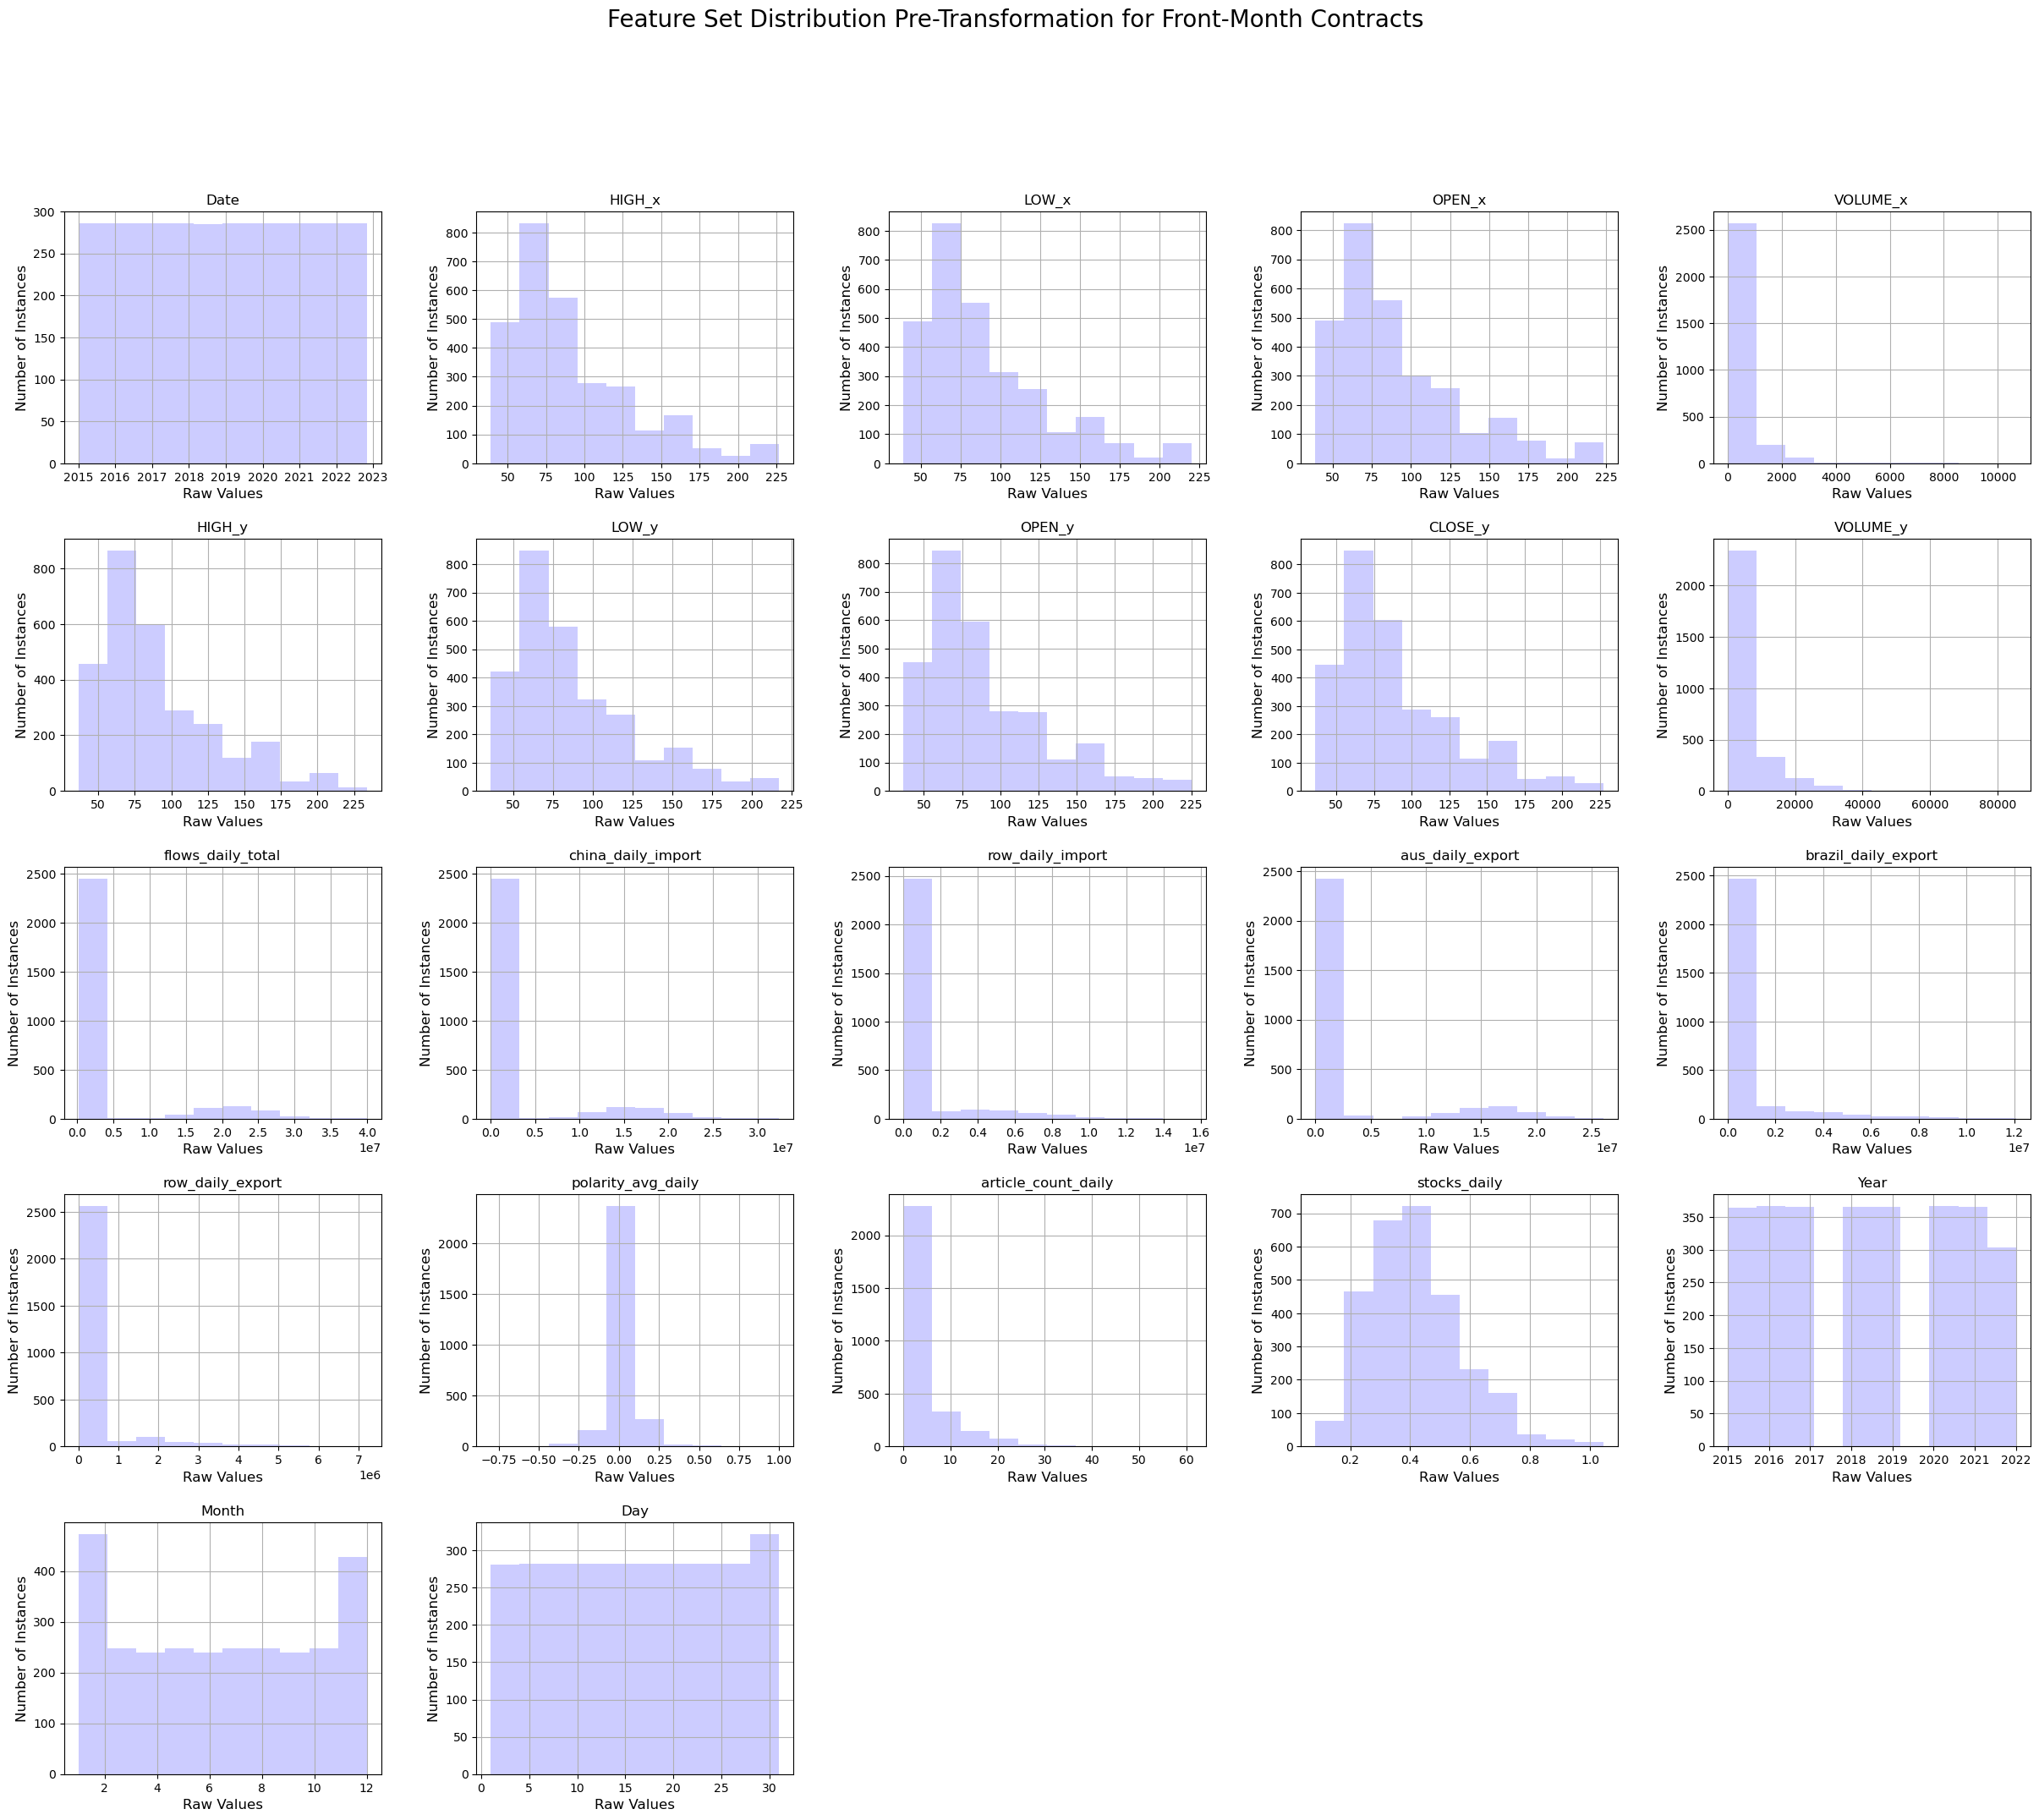

In [23]:
#Checking the distribution of feature set 
X_train_front.hist(figsize=(30, 24), color='blue', alpha=0.2)
plt.suptitle('Feature Set Distribution Pre-Transformation for Front-Month Contracts', fontsize=20)

for ax in plt.gcf().axes:  
    ax.set_xlabel('Raw Values', fontsize=12)
    ax.set_ylabel('Number of Instances', fontsize=12)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

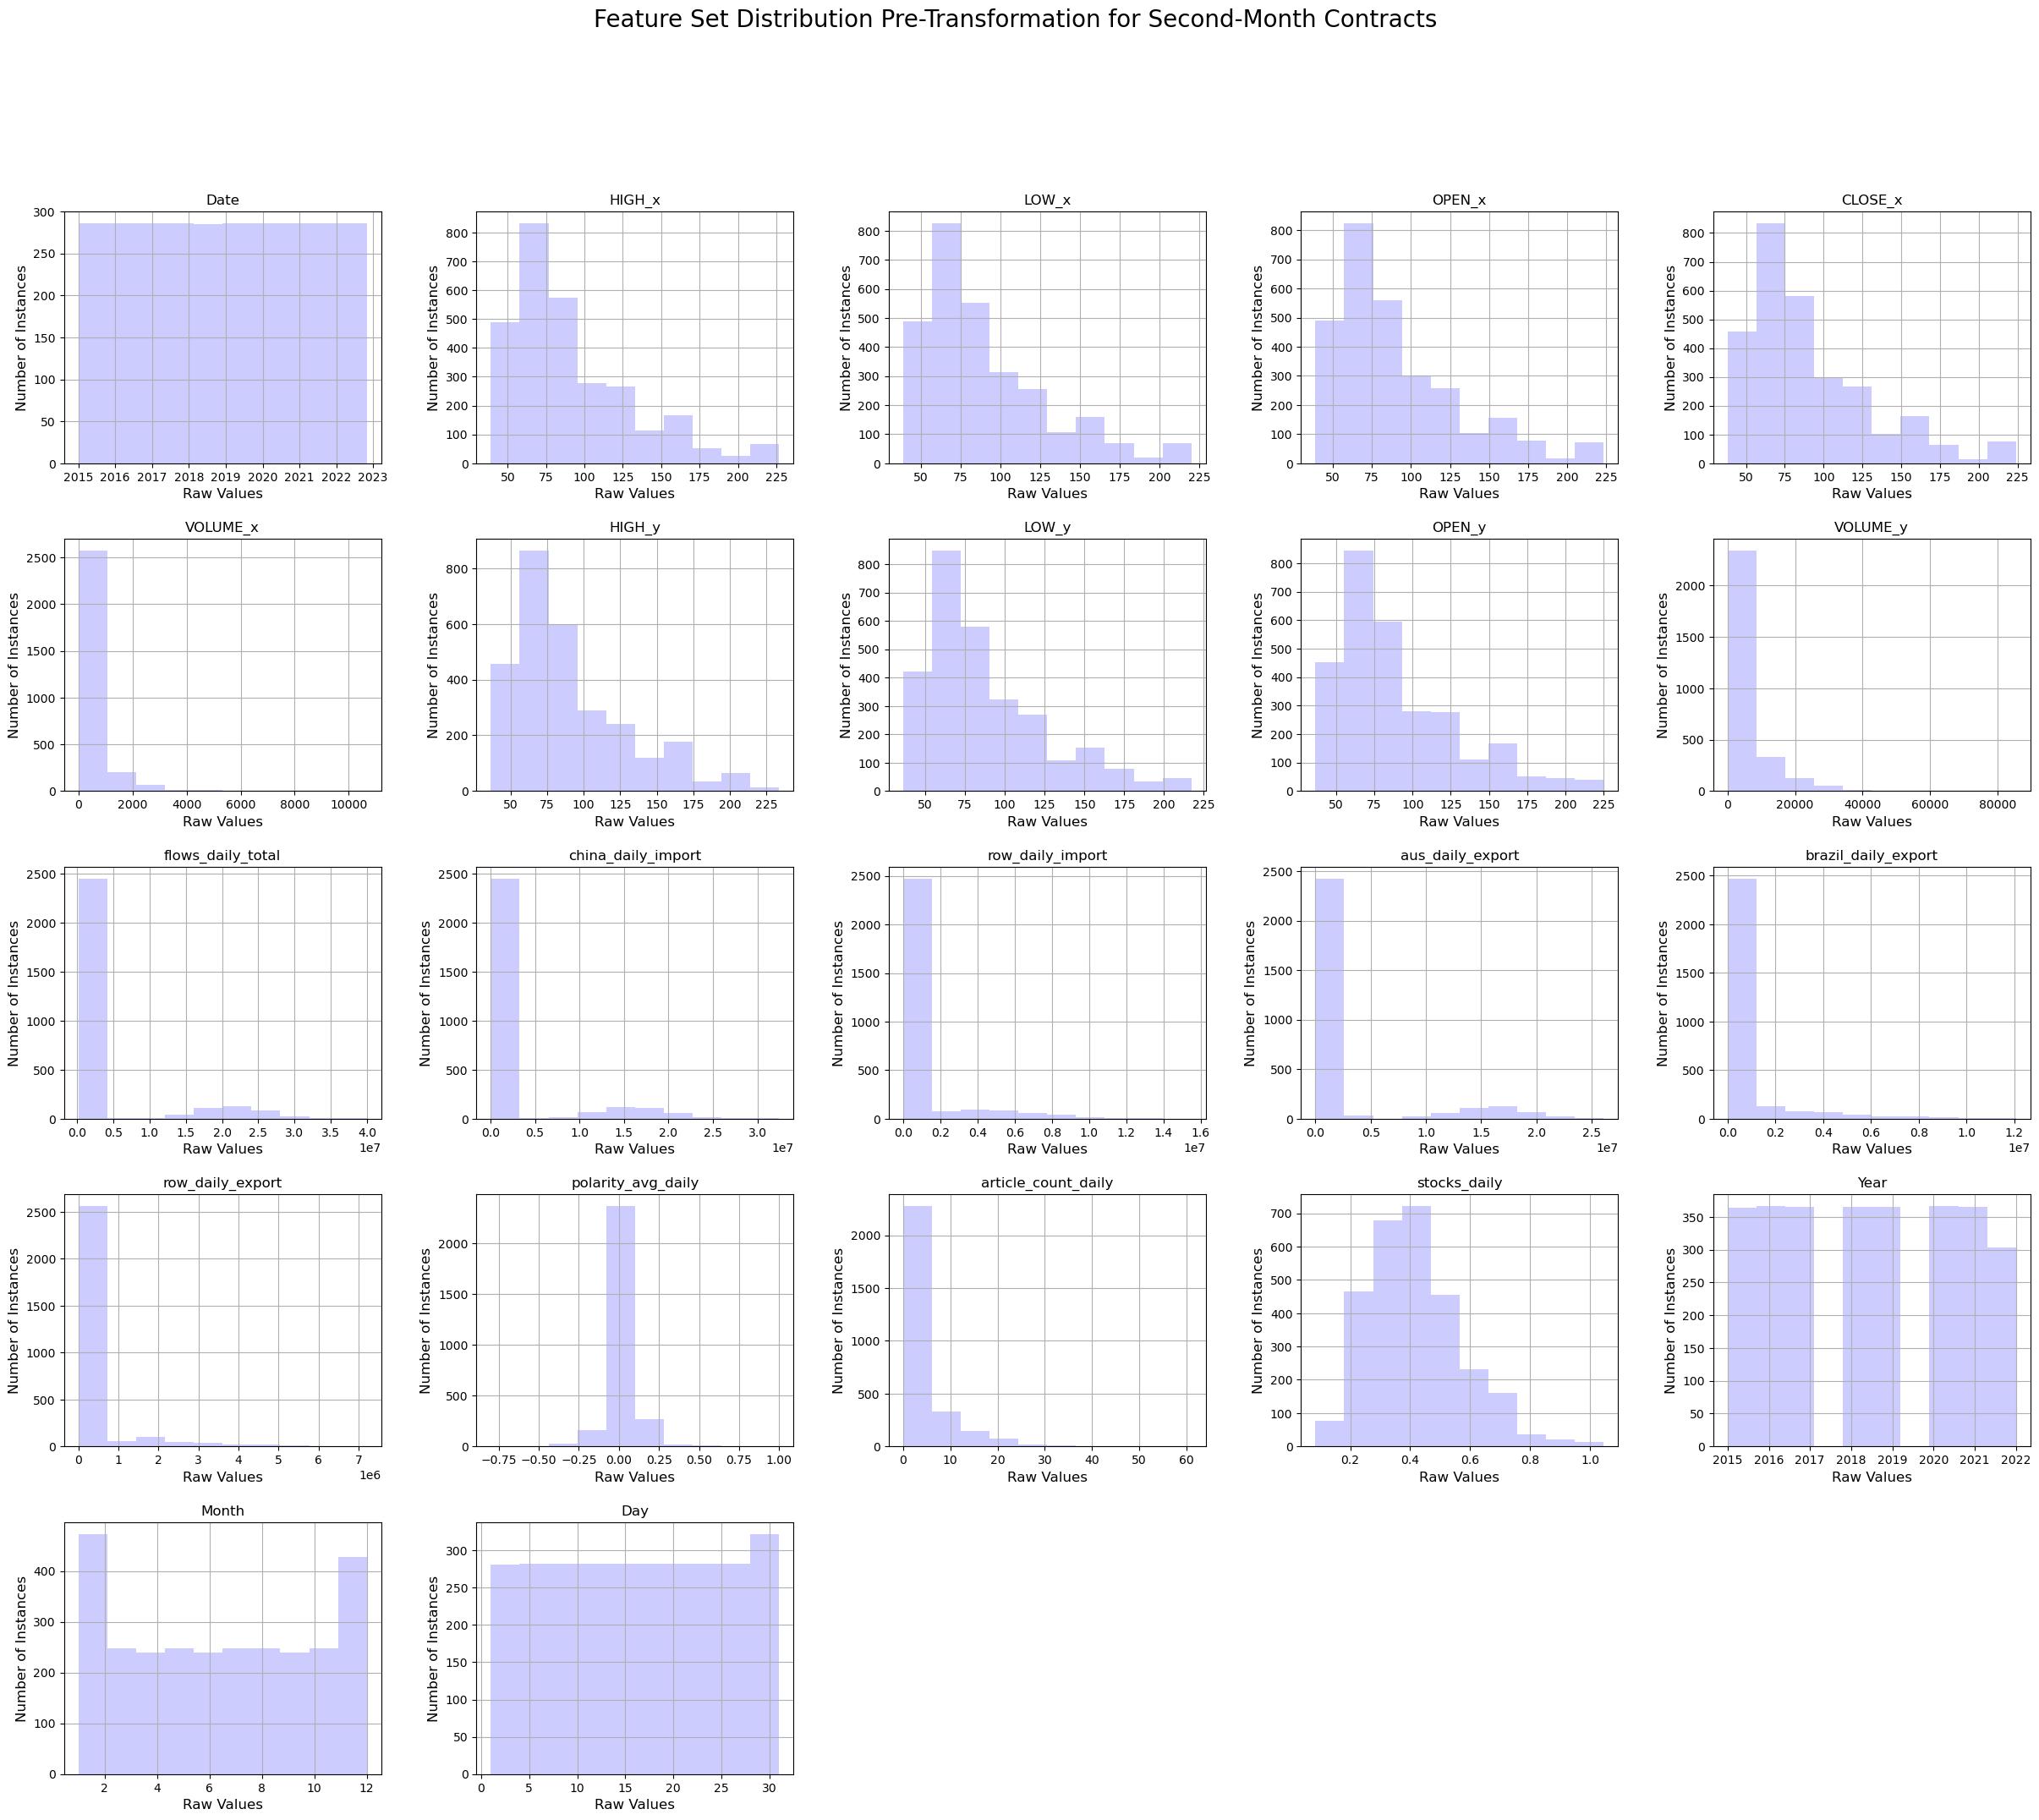

In [24]:
#Checking distribution of the second-month contracts 

X_train_second.hist(figsize=(30, 24), color='blue', alpha=0.2)
plt.suptitle('Feature Set Distribution Pre-Transformation for Second-Month Contracts', fontsize=20)

for ax in plt.gcf().axes:  
    ax.set_xlabel('Raw Values', fontsize=12)
    ax.set_ylabel('Number of Instances', fontsize=12)
plt.show

We observe a skewness in the distribution of certain features and varying scales across the feature set. We also observe the presence of outliers and multi-modal distributions in some cases. We will address through different transformation steps.

## Log Transformation <a class="anchor" id="log-transformation"></a>

In [25]:
X_train_front.columns

Index(['Date', 'HIGH_x', 'LOW_x', 'OPEN_x', 'VOLUME_x', 'HIGH_y', 'LOW_y',
       'OPEN_y', 'CLOSE_y', 'VOLUME_y', 'Overall Sentiment',
       'flows_daily_total', 'china_daily_import', 'row_daily_import',
       'aus_daily_export', 'brazil_daily_export', 'row_daily_export',
       'polarity_avg_daily', 'article_count_daily', 'stocks_daily', 'Year',
       'Month', 'Day'],
      dtype='object')

In [26]:
front_cols_to_transform = ['HIGH_x', 'LOW_x', 'OPEN_x', 'VOLUME_x', 'HIGH_y',
       'LOW_y', 'OPEN_y', 'CLOSE_y', 'VOLUME_y', 'flows_daily_total',
       'china_daily_import', 'row_daily_import', 'aus_daily_export',
       'brazil_daily_export', 'row_daily_export', 'polarity_avg_daily', 
                           'article_count_daily','stocks_daily']

In [27]:
X_train_second.columns

Index(['Date', 'HIGH_x', 'LOW_x', 'OPEN_x', 'CLOSE_x', 'VOLUME_x', 'HIGH_y',
       'LOW_y', 'OPEN_y', 'VOLUME_y', 'Overall Sentiment', 'flows_daily_total',
       'china_daily_import', 'row_daily_import', 'aus_daily_export',
       'brazil_daily_export', 'row_daily_export', 'polarity_avg_daily',
       'article_count_daily', 'stocks_daily', 'Year', 'Month', 'Day'],
      dtype='object')

In [28]:
second_cols_to_transform = ['HIGH_x', 'LOW_x', 'OPEN_x', 'VOLUME_x', 'HIGH_y',
       'LOW_y', 'OPEN_y', 'CLOSE_x', 'VOLUME_y', 'flows_daily_total',
       'china_daily_import', 'row_daily_import', 'aus_daily_export',
       'brazil_daily_export', 'row_daily_export', 'polarity_avg_daily',
       'article_count_daily', 'stocks_daily']

In [29]:
#initialising a log transformer
log_transformer_1 = FunctionTransformer(np.log1p, validate=False)

#Defining data for log transformation
data_to_transform = X_train_front[front_cols_to_transform]

#Fitting and transforming columns in X_train_front
log_X_train_front = log_transformer_1.fit_transform(data_to_transform)

In [30]:
log_X_train_front

,HIGH_x,LOW_x,OPEN_x,VOLUME_x,HIGH_y,LOW_y,OPEN_y,CLOSE_y,VOLUME_y,flows_daily_total,china_daily_import,row_daily_import,aus_daily_export,brazil_daily_export,row_daily_export,polarity_avg_daily,article_count_daily,stocks_daily
0,4.287029,4.287029,4.287029,1.791759,4.283862,4.262257,4.262257,4.266195,4.219508,14.755924,14.389857,13.573529,14.552125,12.710191,11.857122,0.000000,0.000000,0.178565
1,4.287029,4.287029,4.287029,1.791759,4.283862,4.262257,4.262257,4.266195,4.219508,14.060560,13.782746,12.644068,14.005194,0.000000,11.139231,0.000000,0.000000,0.178565
2,4.287029,4.287029,4.287029,1.791759,4.283862,4.262257,4.262257,4.266195,4.219508,14.507042,14.328308,12.697153,14.044338,13.328023,11.739916,0.000000,0.000000,0.178565
3,4.287029,4.287029,4.287029,1.791759,4.283862,4.262257,4.262257,4.254335,4.219508,16.439713,15.928617,15.523828,16.038381,15.073926,13.854670,0.000000,0.000000,0.178565
4,4.287029,4.287029,4.287029,1.791759,4.283862,4.262257,4.262257,4.279302,4.219508,14.282881,13.657107,13.517492,14.060212,11.577428,12.263833,0.000000,0.000000,0.178565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2854,4.551242,4.547011,4.551242,4.634729,4.510860,4.466483,4.496471,4.472096,10.243845,14.983918,14.881513,12.654333,14.583852,13.673337,12.171526,0.106610,1.098612,0.404591
2855,4.547365,4.543117,4.547188,5.563242,4.491441,4.409155,4.472781,4.415341,11.355441,14.586947,14.476533,12.328739,14.122643,12.814462,12.985072,0.125163,0.693147,0.404591
2856,4.543472,4.539208,4.543117,6.036279,4.426044,4.379524,4.425445,4.402932,11.241169,14.795083,14.424999,13.621715,14.330815,13.523307,12.398980,0.167054,0.693147,0.404591
2857,4.543472,4.539208,4.543117,6.036279,4.426044,4.379524,4.425445,4.402932,11.241169,14.678616,14.524218,12.734188,14.354890,12.915199,12.425715,0.000000,0.000000,0.404591


In [31]:
#Defining data for log transformation
data_to_transform_2 = X_test_front[front_cols_to_transform]

#Fitting and transforming columns in X_train_front
log_X_test_front = log_transformer_1.transform(data_to_transform_2)

In [32]:
log_X_test_front.head()

,HIGH_x,LOW_x,OPEN_x,VOLUME_x,HIGH_y,LOW_y,OPEN_y,CLOSE_y,VOLUME_y,flows_daily_total,china_daily_import,row_daily_import,aus_daily_export,brazil_daily_export,row_daily_export,polarity_avg_daily,article_count_daily,stocks_daily
0,4.403666,4.354784,4.378270,9.392245,4.383276,4.334017,4.359909,4.370713,10.383411,14.658998,14.356120,13.316955,14.581645,12.061211,0.000000,0.022658,1.609438,0.063405
1,4.431412,4.387636,4.394449,9.913487,4.412192,4.365008,4.375128,4.400848,10.860555,14.937433,14.616118,13.645743,14.601808,13.110361,12.851777,0.000000,0.000000,0.063405
2,4.439116,4.413404,4.420045,9.462110,4.419443,4.391977,4.401216,4.415461,10.508623,14.746903,14.546577,13.040604,14.555249,12.528012,12.023927,-0.005893,1.386294,0.063405
3,4.543295,4.428433,4.434382,10.185956,4.455800,4.416428,4.435567,4.465333,10.766462,14.796157,14.628755,12.926266,14.599835,12.949668,10.906993,0.000000,0.000000,0.063405
4,4.543295,4.428433,4.434382,10.185956,4.455800,4.416428,4.435567,4.465333,10.766462,14.825610,14.671450,12.879756,14.523754,12.763133,12.811335,0.000000,0.000000,0.063405


In [33]:
#Defining log transformer for second-month X datasets
log_transformer_2 = FunctionTransformer(np.log1p, validate=False)

#Defining data for log transformation
data_to_transform_3 = X_train_second[second_cols_to_transform]

#Fitting and transforming columns in X_train_front
log_X_train_second = log_transformer_2.fit_transform(data_to_transform_3)

In [34]:
#Defining data for log transformation
data_to_transform_4 = X_test_second[second_cols_to_transform]

#Fitting and transforming columns in X_train_front
log_X_test_second = log_transformer_2.transform(data_to_transform_4)

In [35]:
log_X_train_second.columns

Index(['HIGH_x', 'LOW_x', 'OPEN_x', 'VOLUME_x', 'HIGH_y', 'LOW_y', 'OPEN_y',
       'CLOSE_x', 'VOLUME_y', 'flows_daily_total', 'china_daily_import',
       'row_daily_import', 'aus_daily_export', 'brazil_daily_export',
       'row_daily_export', 'polarity_avg_daily', 'article_count_daily',
       'stocks_daily'],
      dtype='object')

In [36]:
#Merging log-scaled columns back with original df

log_X_train_front.rename(columns={col: col + '_log' for col in log_X_train_front.columns}, inplace=True)

X_train_front_log_transformed = pd.concat([X_train_front, log_X_train_front], axis=1)

#Dropping raw value columns in original df
X_train_front_log_transformed.drop(columns=front_cols_to_transform, inplace=True)

In [37]:
#Merging log-scaled columns back with original test df

log_X_test_front.rename(columns={col: col + '_log' for col in log_X_test_front.columns}, inplace=True)

X_test_front_log_transformed = pd.concat([X_test_front, log_X_test_front], axis=1)

#Dropping raw value columns from test set
X_test_front_log_transformed.drop(columns=front_cols_to_transform, inplace=True)

In [38]:
##For second-month 

#Merging log-scaled columns back with original df

log_X_train_second.rename(columns={col: col + '_log' for col in log_X_train_second.columns}, inplace=True)

X_train_second_log_transformed = pd.concat([X_train_second, log_X_train_second], axis=1)

#Dropping raw value columns in original df
X_train_second_log_transformed.drop(columns=second_cols_to_transform, inplace=True)

In [39]:
#Merging log-scaled columns back with original test df

log_X_test_second.rename(columns={col: col + '_log' for col in log_X_test_second.columns}, inplace=True)

X_test_second_log_transformed = pd.concat([X_test_second, log_X_test_second], axis=1)

#Dropping raw value columns in test set
X_test_second_log_transformed.drop(columns=second_cols_to_transform, inplace=True)

#### Post Log-Transform Distribution

<function matplotlib.pyplot.show(close=None, block=None)>

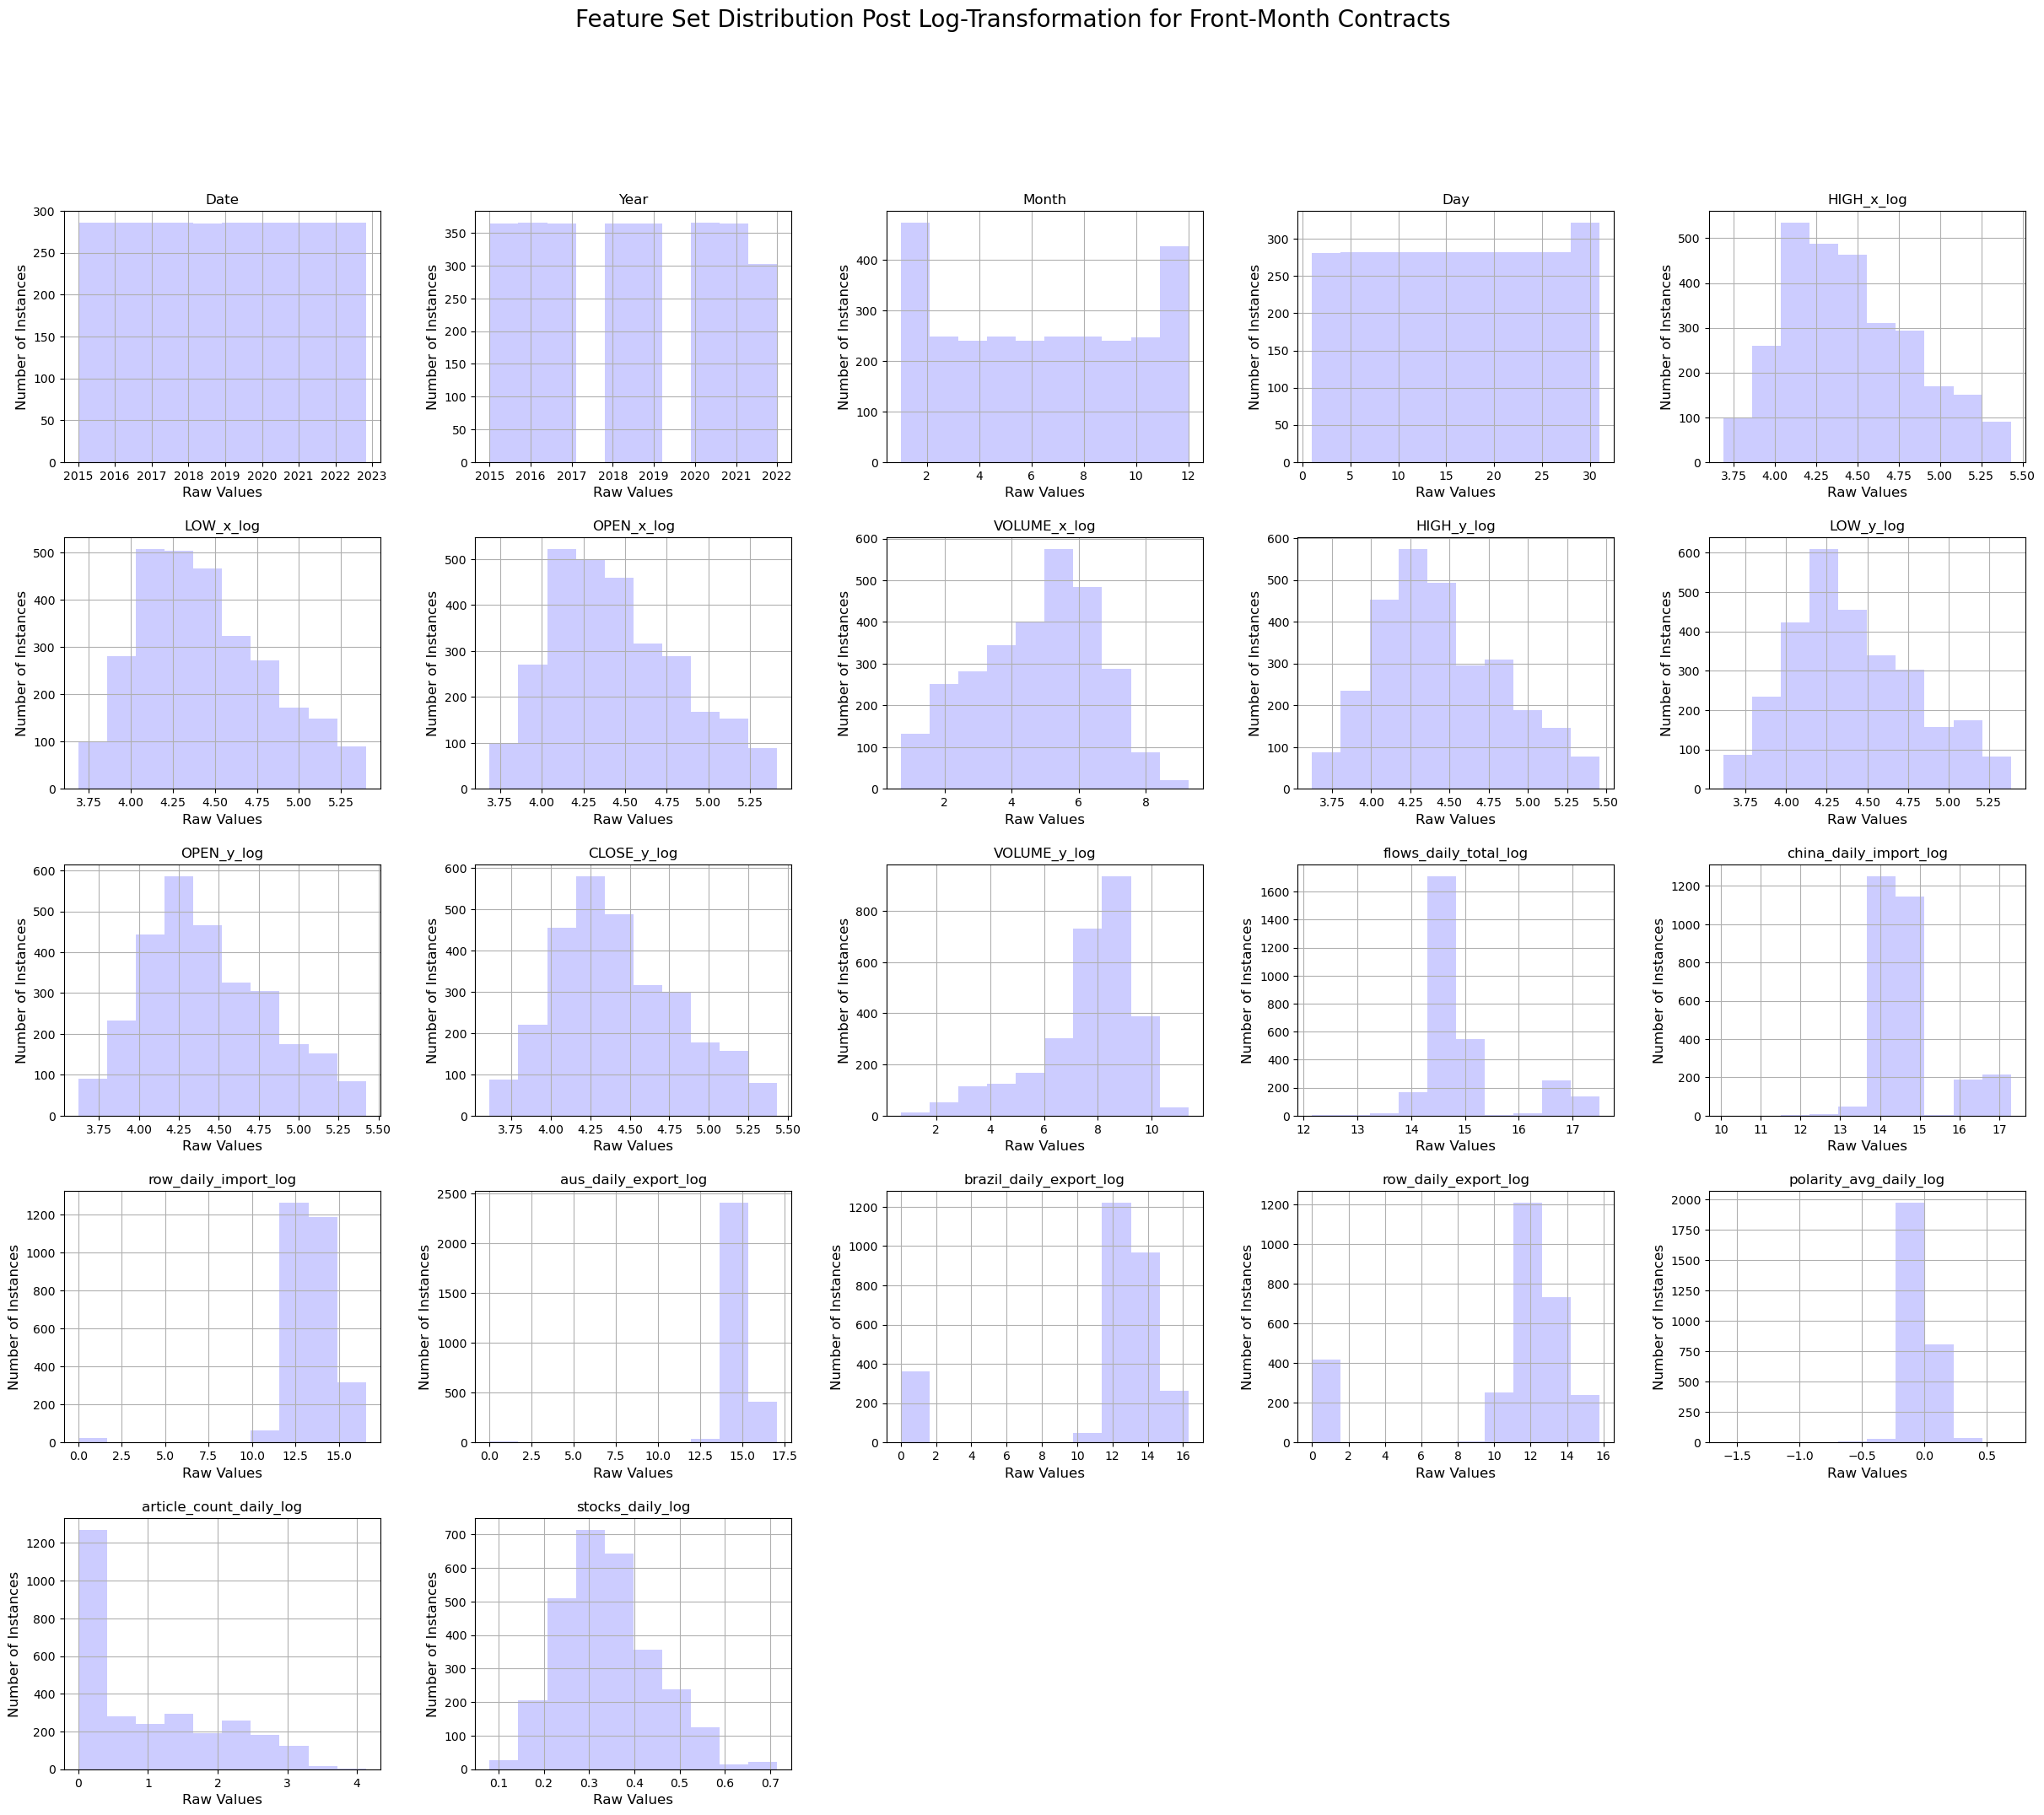

In [40]:
#Checking the distribution of feature set post log-transformation
X_train_front_log_transformed.hist(figsize=(30, 24), color='blue', alpha=0.2)
plt.suptitle('Feature Set Distribution Post Log-Transformation for Front-Month Contracts', fontsize=20)

for ax in plt.gcf().axes:  
    ax.set_xlabel('Raw Values', fontsize=12)
    ax.set_ylabel('Number of Instances', fontsize=12)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

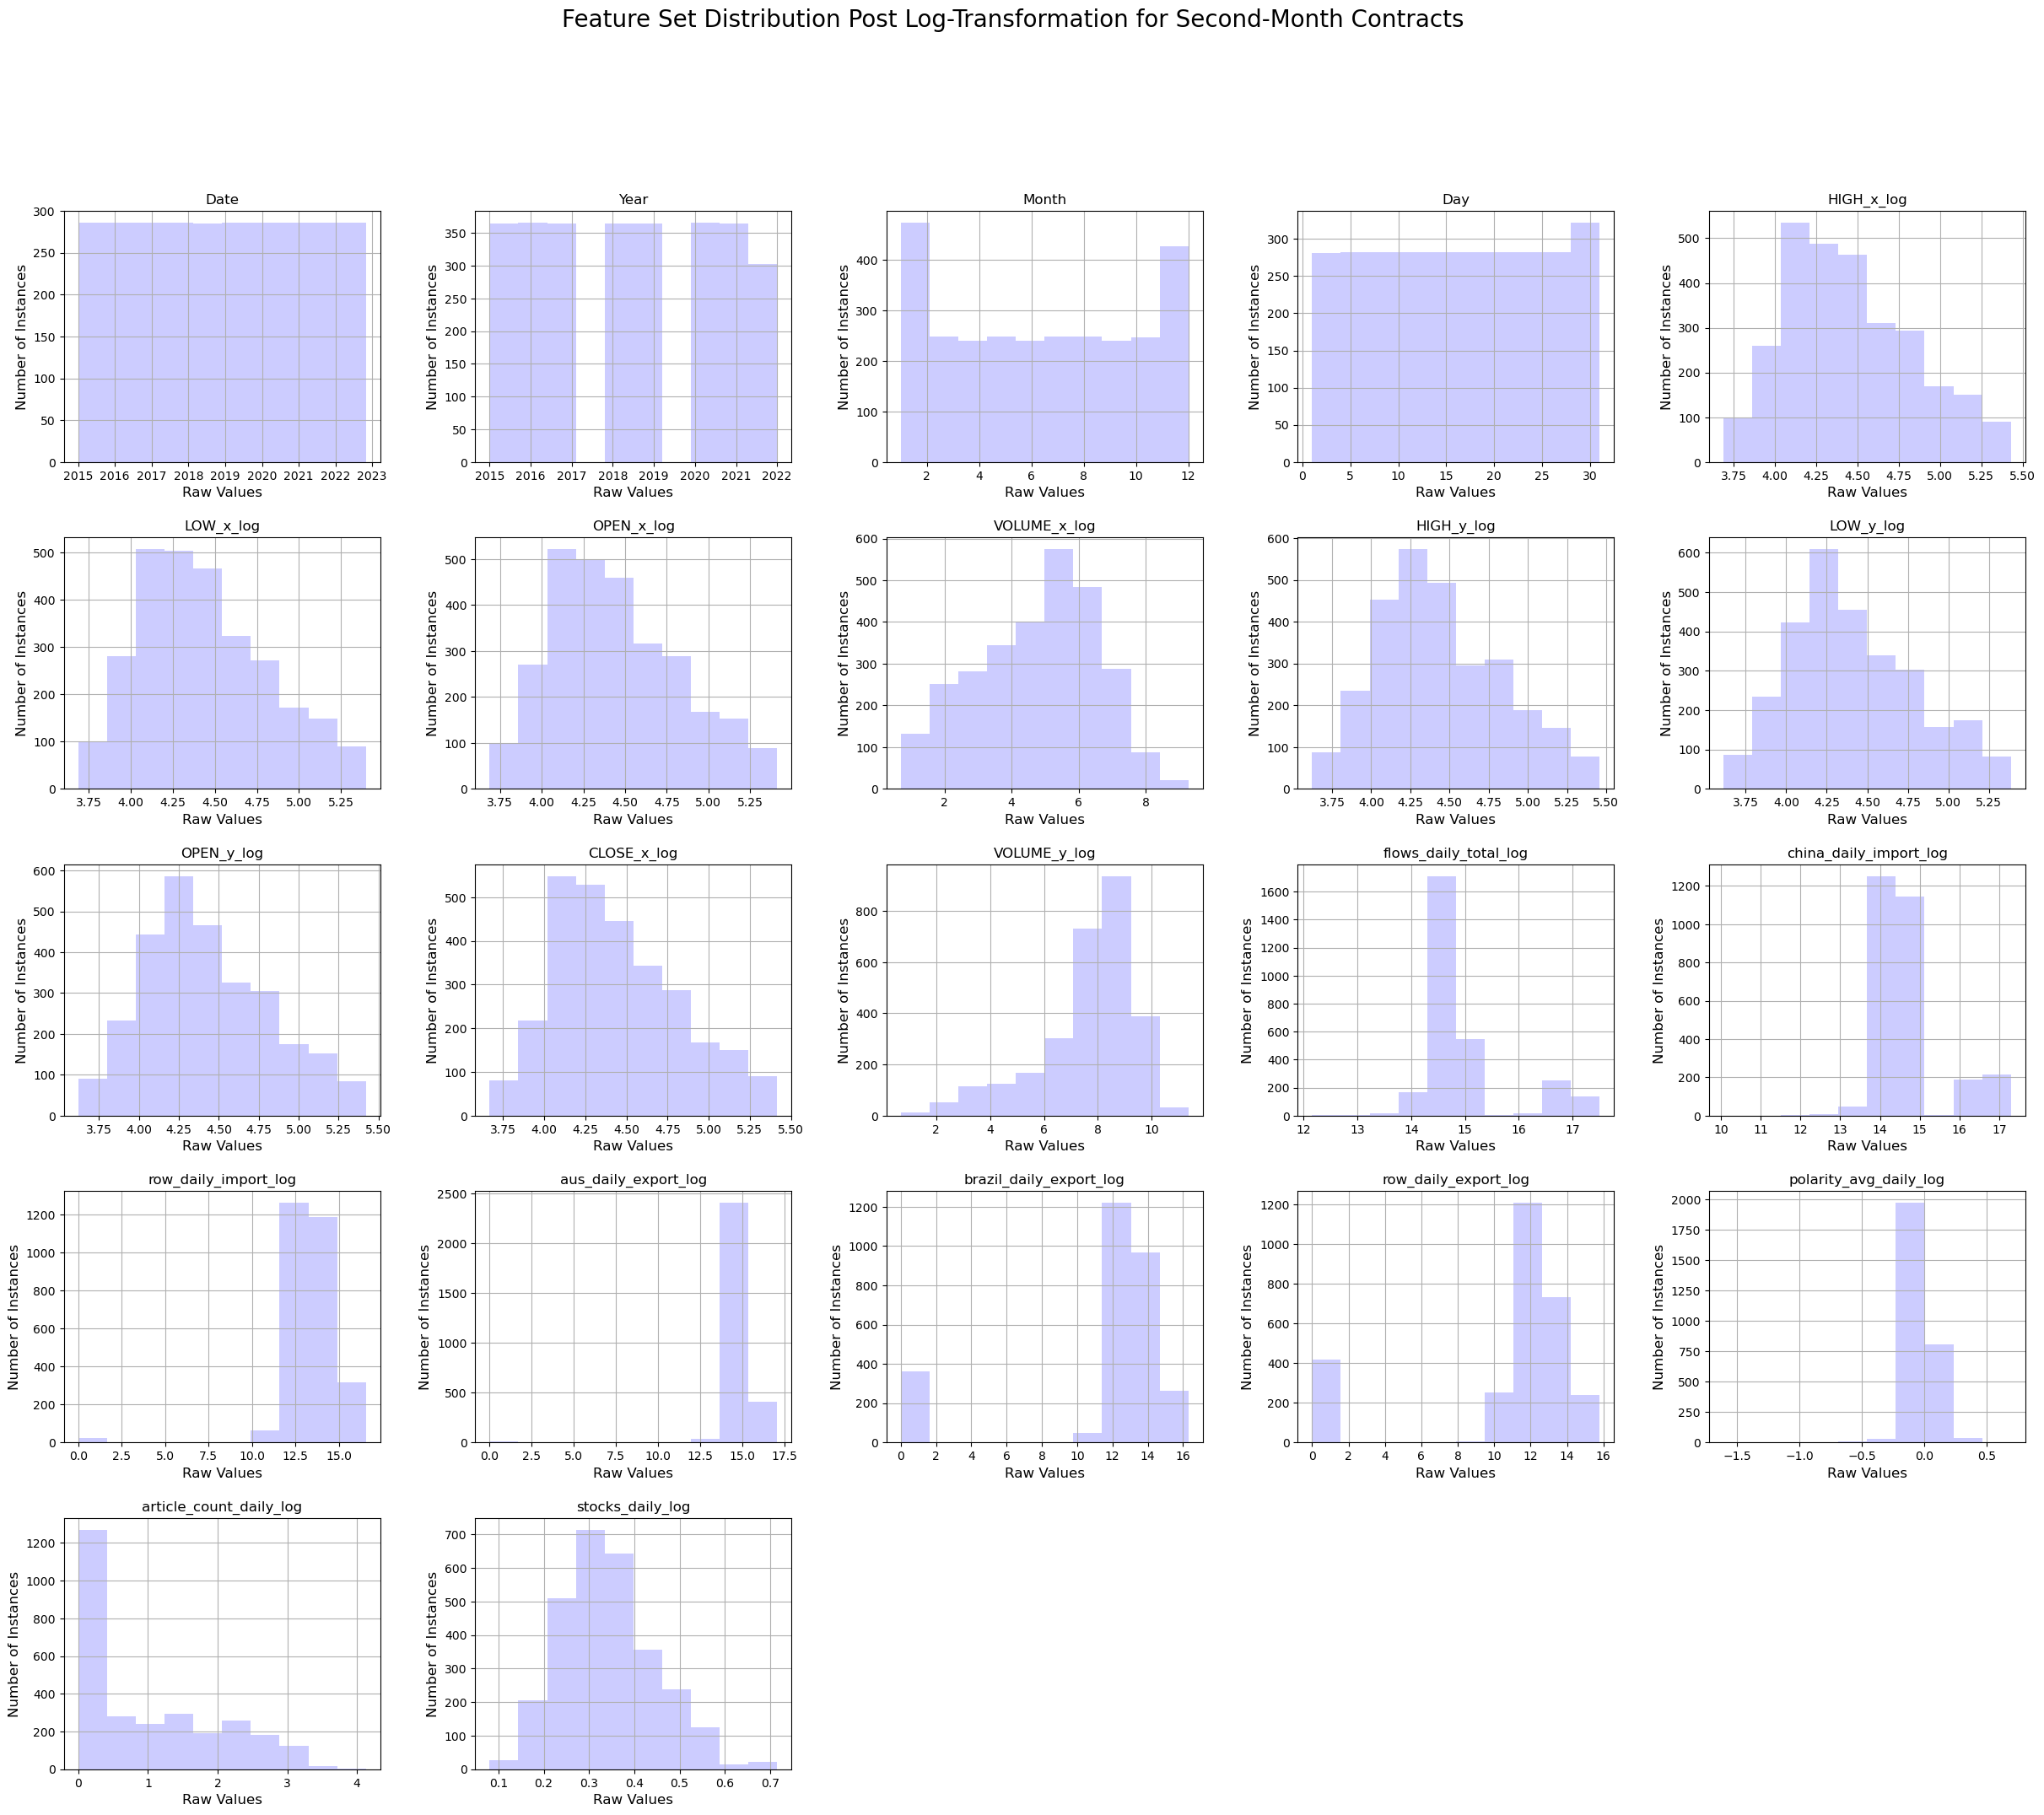

In [41]:
#Checking the distribution of feature set for second-month contracts post log-transformation
X_train_second_log_transformed.hist(figsize=(30, 24), color='blue', alpha=0.2)
plt.suptitle('Feature Set Distribution Post Log-Transformation for Second-Month Contracts', fontsize=20)

for ax in plt.gcf().axes:  
    ax.set_xlabel('Raw Values', fontsize=12)
    ax.set_ylabel('Number of Instances', fontsize=12)
plt.show

We have been able to normalise to a fair extent the distribution with the log transformation alone. However, we observe that certain data show multi-modal distributions which we shall investigate this further.

## Gaussian Mixture-Models & Cluster Identification <a class="anchor" id="gmm-cluster"></a>

/Users/rg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


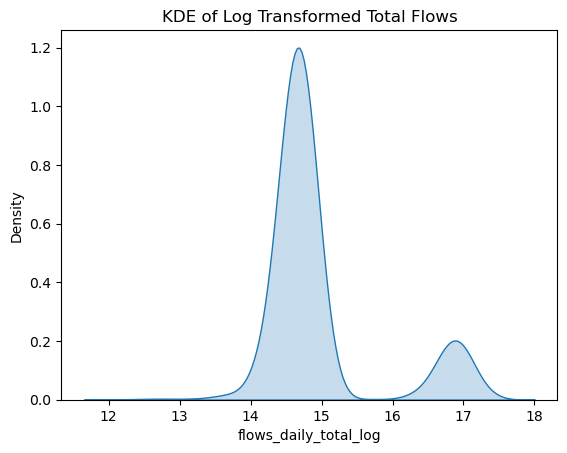

In [42]:
#Plotting Kernel Density for Total Flows
sns.kdeplot(X_train_front_log_transformed['flows_daily_total_log'], fill=True)
plt.title('KDE of Log Transformed Total Flows')
plt.show()

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_3708/1374546949.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train_second_log_transformed['flows_daily_total_log'], shade=True)
/Users/rg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


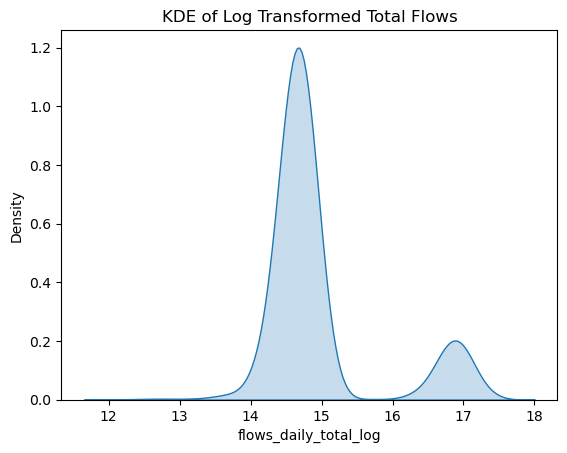

In [43]:
#Plotting Kernel Density for Total Flows
sns.kdeplot(X_train_second_log_transformed['flows_daily_total_log'], shade=True)
plt.title('KDE of Log Transformed Total Flows')
plt.show()

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_3708/3419670758.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train_front_log_transformed['china_daily_import_log'], shade=True)
/Users/rg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


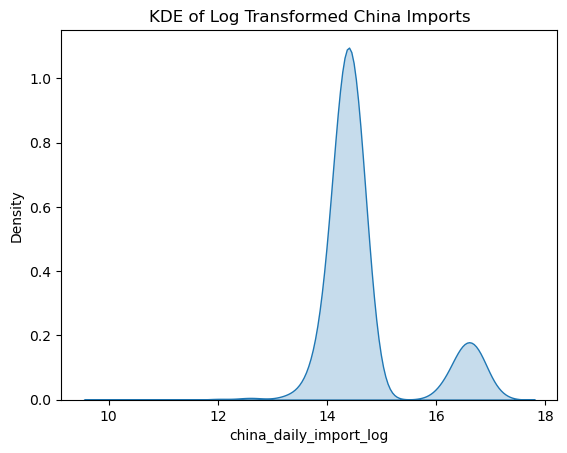

In [44]:
#Plotting Kernel Density for China imports
sns.kdeplot(X_train_front_log_transformed['china_daily_import_log'], shade=True)
plt.title('KDE of Log Transformed China Imports')
plt.show()

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_3708/672596899.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train_second_log_transformed['china_daily_import_log'], shade=True)
/Users/rg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


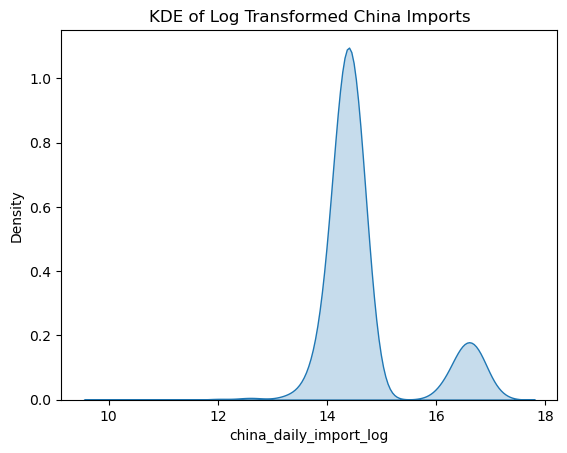

In [45]:
#Plotting Kernel Density for China imports
sns.kdeplot(X_train_second_log_transformed['china_daily_import_log'], shade=True)
plt.title('KDE of Log Transformed China Imports')
plt.show()

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_3708/4086030884.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train_front_log_transformed['brazil_daily_export_log'], shade=True)
/Users/rg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


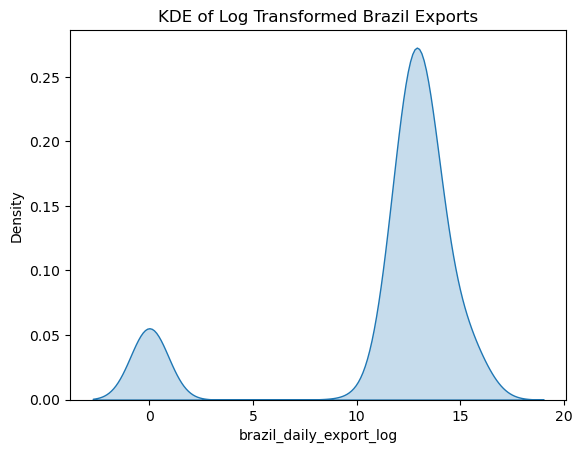

In [46]:
#Plotting Kernel Density for Brazil exports
sns.kdeplot(X_train_front_log_transformed['brazil_daily_export_log'], shade=True)
plt.title('KDE of Log Transformed Brazil Exports')
plt.show()

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_3708/4000682647.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train_second_log_transformed['brazil_daily_export_log'], shade=True)
/Users/rg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


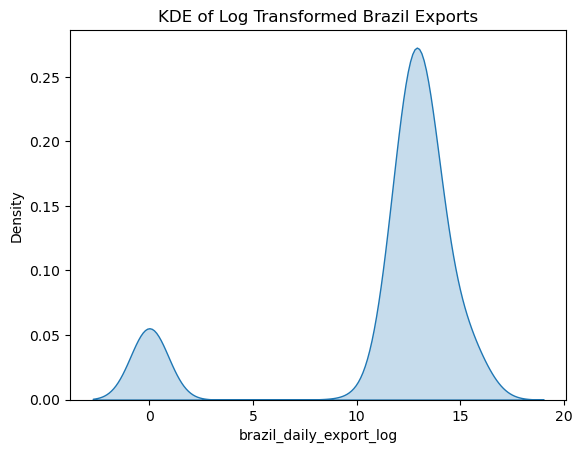

In [47]:
#Plotting Kernel Density for Brazil exports
sns.kdeplot(X_train_second_log_transformed['brazil_daily_export_log'], shade=True)
plt.title('KDE of Log Transformed Brazil Exports')
plt.show()

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_3708/816204036.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train_front_log_transformed['row_daily_export_log'], shade=True)
/Users/rg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


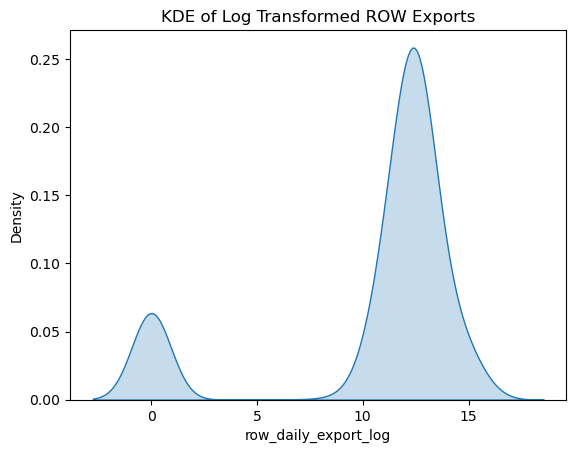

In [48]:
#Plotting Kernel Density for ROW exports
sns.kdeplot(X_train_front_log_transformed['row_daily_export_log'], shade=True)
plt.title('KDE of Log Transformed ROW Exports')
plt.show()

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_3708/753844435.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train_second_log_transformed['row_daily_export_log'], shade=True)
/Users/rg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


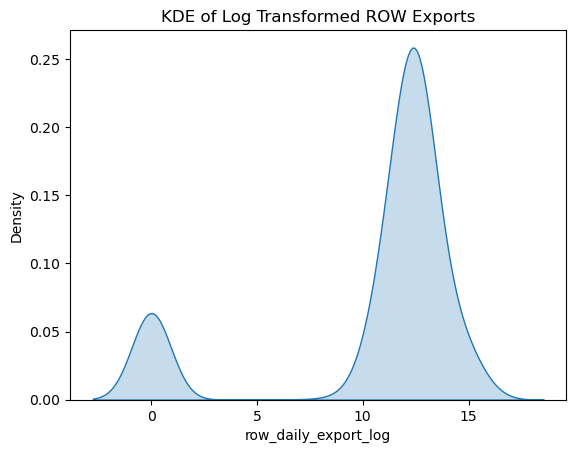

In [49]:
#Plotting Kernel Density for ROW exports
sns.kdeplot(X_train_second_log_transformed['row_daily_export_log'], shade=True)
plt.title('KDE of Log Transformed ROW Exports')
plt.show()

We can observe bi-modal distributions for these data columns from the Kernel Density Estimate plots. We will now proceed to identify the clusters within each distribution. 

In [50]:
#Creating list of columns for clustering
gmm_cols = ['flows_daily_total_log', 'china_daily_import_log',  'brazil_daily_export_log', 'row_daily_export_log']

In [51]:
summary_stats_1 = []

#Adding dummy variables for each cluster within the df
for col in gmm_cols:
    gmm = GaussianMixture(n_components=2, random_state=42)  #n_components equals number of modes observed
    gmm.fit(X_train_front_log_transformed[[col]])
    cluster_column_name = f"{col}_cluster"
    X_train_front_log_transformed[cluster_column_name] = gmm.predict(X_train_front_log_transformed[[col]])

 #Calculating summary statistics for each cluster
    stats = X_train_front_log_transformed.groupby(cluster_column_name)[col].describe()
    stats['column'] = col  # Add column name to the stats
    stats['cluster'] = stats.index  # Add cluster number to the stats
    summary_stats_1.append(stats.reset_index(drop=True))

#Combining all summary statistics into a single DataFrame
summary_df_1 = pd.concat(summary_stats_1, ignore_index=True)

#Ordering columns
summary_df_1 = summary_df_1[['column', 'cluster', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

In [52]:
summary_df_1

,column,cluster,count,mean,std,min,25%,50%,75%,max
0,flows_daily_total_log,0,2454.0,14.636904,0.274360,12.154931,14.497962,14.659566,14.809717,15.785263
1,flows_daily_total_log,1,405.0,16.862345,0.234880,16.106001,16.726109,16.871557,17.016923,17.503741
2,china_daily_import_log,0,2454.0,14.348769,0.317700,10.057590,14.201098,14.373177,14.551312,15.188620
3,china_daily_import_log,1,405.0,16.584177,0.265265,15.759572,16.407613,16.589850,16.767287,17.294619
4,brazil_daily_export_log,0,360.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,brazil_daily_export_log,1,2499.0,13.144643,1.029580,8.879540,12.451772,13.011521,13.545572,16.305862
6,row_daily_export_log,0,2439.0,12.468368,1.082404,6.919073,11.992232,12.414870,12.916249,15.790039
7,row_daily_export_log,1,420.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [53]:
X_train_front_log_transformed.head()

,Date,Overall Sentiment,Year,Month,Day,HIGH_x_log,LOW_x_log,OPEN_x_log,VOLUME_x_log,HIGH_y_log,...,aus_daily_export_log,brazil_daily_export_log,row_daily_export_log,polarity_avg_daily_log,article_count_daily_log,stocks_daily_log,flows_daily_total_log_cluster,china_daily_import_log_cluster,brazil_daily_export_log_cluster,row_daily_export_log_cluster
0,2015-01-02,Neutral,2015,1,2,4.287029,4.287029,4.287029,1.791759,4.283862,...,14.552125,12.710191,11.857122,0.0,0.0,0.178565,0,0,1,0
1,2015-01-03,Neutral,2015,1,3,4.287029,4.287029,4.287029,1.791759,4.283862,...,14.005194,0.000000,11.139231,0.0,0.0,0.178565,0,0,0,0
2,2015-01-04,Neutral,2015,1,4,4.287029,4.287029,4.287029,1.791759,4.283862,...,14.044338,13.328023,11.739916,0.0,0.0,0.178565,0,0,1,0
3,2015-01-05,Neutral,2015,1,5,4.287029,4.287029,4.287029,1.791759,4.283862,...,16.038381,15.073926,13.854670,0.0,0.0,0.178565,1,1,1,0
4,2015-01-06,Neutral,2015,1,6,4.287029,4.287029,4.287029,1.791759,4.283862,...,14.060212,11.577428,12.263833,0.0,0.0,0.178565,0,0,1,0


In [54]:
#Adding columns to test set

for col in gmm_cols:
    gmm = GaussianMixture(n_components=2, random_state=42)  
    gmm.fit(X_test_front_log_transformed[[col]])
    cluster_column_name = f"{col}_cluster"
    X_test_front_log_transformed[cluster_column_name] = gmm.predict(X_test_front_log_transformed[[col]])

In [55]:
X_test_front_log_transformed.head()

,Date,Overall Sentiment,Year,Month,Day,HIGH_x_log,LOW_x_log,OPEN_x_log,VOLUME_x_log,HIGH_y_log,...,aus_daily_export_log,brazil_daily_export_log,row_daily_export_log,polarity_avg_daily_log,article_count_daily_log,stocks_daily_log,flows_daily_total_log_cluster,china_daily_import_log_cluster,brazil_daily_export_log_cluster,row_daily_export_log_cluster
0,2022-11-01,Non-neutral,2022,11,1,4.403666,4.354784,4.378270,9.392245,4.383276,...,14.581645,12.061211,0.000000,0.022658,1.609438,0.063405,0,0,0,1
1,2022-11-02,Neutral,2022,11,2,4.431412,4.387636,4.394449,9.913487,4.412192,...,14.601808,13.110361,12.851777,0.000000,0.000000,0.063405,0,0,0,0
2,2022-11-03,Non-neutral,2022,11,3,4.439116,4.413404,4.420045,9.462110,4.419443,...,14.555249,12.528012,12.023927,-0.005893,1.386294,0.063405,0,0,0,0
3,2022-11-04,Neutral,2022,11,4,4.543295,4.428433,4.434382,10.185956,4.455800,...,14.599835,12.949668,10.906993,0.000000,0.000000,0.063405,0,0,0,0
4,2022-11-05,Neutral,2022,11,5,4.543295,4.428433,4.434382,10.185956,4.455800,...,14.523754,12.763133,12.811335,0.000000,0.000000,0.063405,0,0,0,0


In [56]:
#Repeating clustering steps for second-month

summary_stats_2 = []

#Adding dummy variables for each cluster within the df
for col in gmm_cols:
    gmm = GaussianMixture(n_components=2, random_state=42)  # Adjust n_components as needed
    gmm.fit(X_train_second_log_transformed[[col]])
    cluster_column_name = f"{col}_cluster"
    X_train_second_log_transformed[cluster_column_name] = gmm.predict(X_train_second_log_transformed[[col]])

 #Calculating summary statistics for each cluster
    stats = X_train_second_log_transformed.groupby(cluster_column_name)[col].describe()
    stats['column'] = col  # Add column name to the stats
    stats['cluster'] = stats.index  # Add cluster number to the stats
    summary_stats_2.append(stats.reset_index(drop=True))

summary_df_2 = pd.concat(summary_stats_2, ignore_index=True)

summary_df_2 = summary_df_2[['column', 'cluster', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

In [57]:
summary_df_2 

,column,cluster,count,mean,std,min,25%,50%,75%,max
0,flows_daily_total_log,0,2454.0,14.636904,0.274360,12.154931,14.497962,14.659566,14.809717,15.785263
1,flows_daily_total_log,1,405.0,16.862345,0.234880,16.106001,16.726109,16.871557,17.016923,17.503741
2,china_daily_import_log,0,2454.0,14.348769,0.317700,10.057590,14.201098,14.373177,14.551312,15.188620
3,china_daily_import_log,1,405.0,16.584177,0.265265,15.759572,16.407613,16.589850,16.767287,17.294619
4,brazil_daily_export_log,0,360.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,brazil_daily_export_log,1,2499.0,13.144643,1.029580,8.879540,12.451772,13.011521,13.545572,16.305862
6,row_daily_export_log,0,2439.0,12.468368,1.082404,6.919073,11.992232,12.414870,12.916249,15.790039
7,row_daily_export_log,1,420.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [58]:
X_train_second_log_transformed.head()

,Date,Overall Sentiment,Year,Month,Day,HIGH_x_log,LOW_x_log,OPEN_x_log,VOLUME_x_log,HIGH_y_log,...,aus_daily_export_log,brazil_daily_export_log,row_daily_export_log,polarity_avg_daily_log,article_count_daily_log,stocks_daily_log,flows_daily_total_log_cluster,china_daily_import_log_cluster,brazil_daily_export_log_cluster,row_daily_export_log_cluster
0,2015-01-02,Neutral,2015,1,2,4.287029,4.287029,4.287029,1.791759,4.283862,...,14.552125,12.710191,11.857122,0.0,0.0,0.178565,0,0,1,0
1,2015-01-03,Neutral,2015,1,3,4.287029,4.287029,4.287029,1.791759,4.283862,...,14.005194,0.000000,11.139231,0.0,0.0,0.178565,0,0,0,0
2,2015-01-04,Neutral,2015,1,4,4.287029,4.287029,4.287029,1.791759,4.283862,...,14.044338,13.328023,11.739916,0.0,0.0,0.178565,0,0,1,0
3,2015-01-05,Neutral,2015,1,5,4.287029,4.287029,4.287029,1.791759,4.283862,...,16.038381,15.073926,13.854670,0.0,0.0,0.178565,1,1,1,0
4,2015-01-06,Neutral,2015,1,6,4.287029,4.287029,4.287029,1.791759,4.283862,...,14.060212,11.577428,12.263833,0.0,0.0,0.178565,0,0,1,0


In [59]:
#Adding columns to test set

for col in gmm_cols:
    gmm = GaussianMixture(n_components=2, random_state=42)  
    gmm.fit(X_test_second_log_transformed[[col]])
    cluster_column_name = f"{col}_cluster"
    X_test_second_log_transformed[cluster_column_name] = gmm.predict(X_test_second_log_transformed[[col]])

In [60]:
X_test_second_log_transformed.head()

,Date,Overall Sentiment,Year,Month,Day,HIGH_x_log,LOW_x_log,OPEN_x_log,VOLUME_x_log,HIGH_y_log,...,aus_daily_export_log,brazil_daily_export_log,row_daily_export_log,polarity_avg_daily_log,article_count_daily_log,stocks_daily_log,flows_daily_total_log_cluster,china_daily_import_log_cluster,brazil_daily_export_log_cluster,row_daily_export_log_cluster
0,2022-11-01,Non-neutral,2022,11,1,4.403666,4.354784,4.378270,9.392245,4.383276,...,14.581645,12.061211,0.000000,0.022658,1.609438,0.063405,0,0,0,1
1,2022-11-02,Neutral,2022,11,2,4.431412,4.387636,4.394449,9.913487,4.412192,...,14.601808,13.110361,12.851777,0.000000,0.000000,0.063405,0,0,0,0
2,2022-11-03,Non-neutral,2022,11,3,4.439116,4.413404,4.420045,9.462110,4.419443,...,14.555249,12.528012,12.023927,-0.005893,1.386294,0.063405,0,0,0,0
3,2022-11-04,Neutral,2022,11,4,4.543295,4.428433,4.434382,10.185956,4.455800,...,14.599835,12.949668,10.906993,0.000000,0.000000,0.063405,0,0,0,0
4,2022-11-05,Neutral,2022,11,5,4.543295,4.428433,4.434382,10.185956,4.455800,...,14.523754,12.763133,12.811335,0.000000,0.000000,0.063405,0,0,0,0


### Transforming Target Variable 

In [61]:
y_train_front.set_index('Date', inplace=True)

y_train_second.set_index('Date', inplace=True)

In [62]:
#Repeating on test 

y_test_front.set_index('Date', inplace=True)
y_test_second.set_index('Date', inplace=True)

<Axes: >

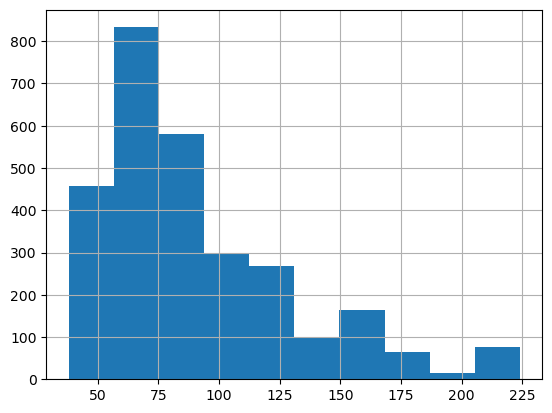

In [63]:
y_train_front['CLOSE_x'].hist()

/Users/rg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


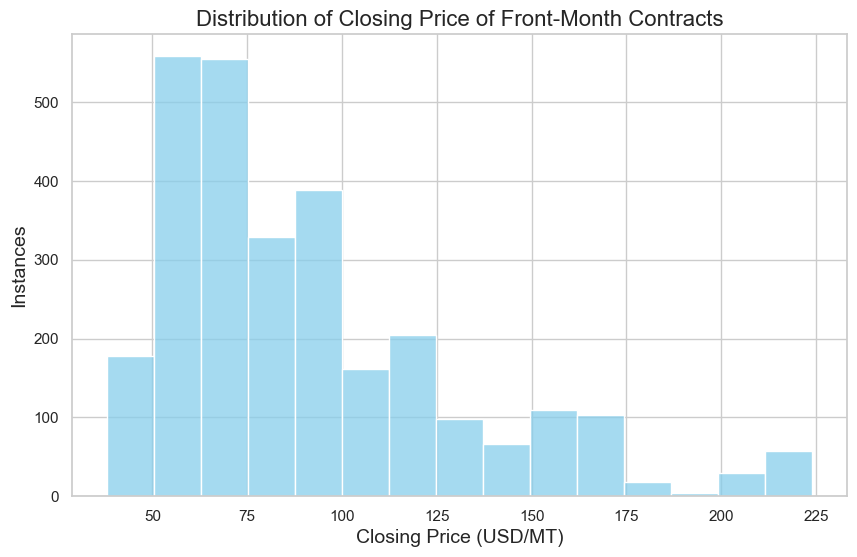

In [64]:
#Plotting pre-transformation distribution of front-month closing price

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(y_train_front['CLOSE_x'], bins=15, kde=False, color='skyblue')

plt.title('Distribution of Closing Price of Front-Month Contracts', fontsize=16)
plt.xlabel('Closing Price (USD/MT)', fontsize=14)
plt.ylabel('Instances', fontsize=14)

plt.show()

<Axes: >

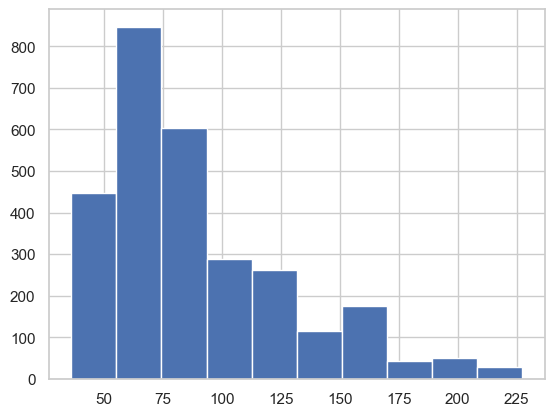

In [65]:
y_train_second['CLOSE_y'].hist()

/Users/rg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


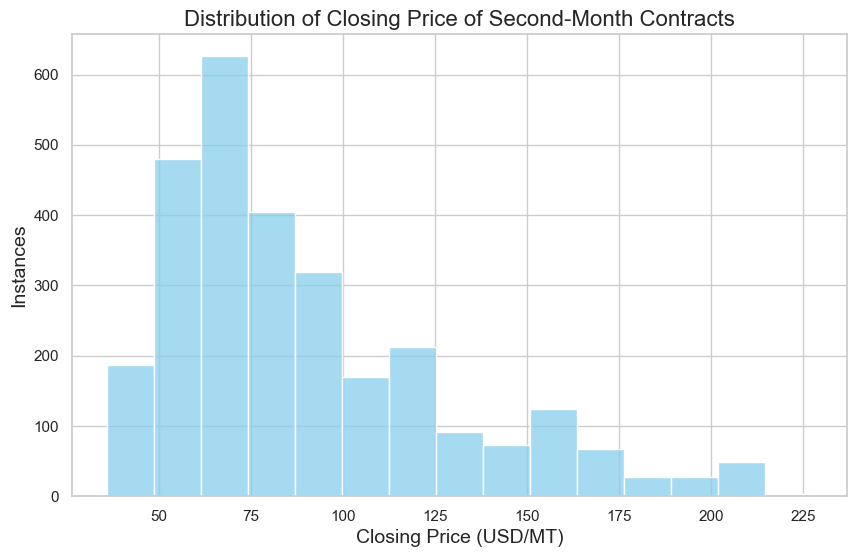

In [66]:
#Plotting pre-transformation distribution of second-month closing price

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(y_train_second['CLOSE_y'], bins=15, kde=False, color='skyblue')

plt.title('Distribution of Closing Price of Second-Month Contracts', fontsize=16)
plt.xlabel('Closing Price (USD/MT)', fontsize=14)
plt.ylabel('Instances', fontsize=14)

plt.show()

In [67]:
#Initialising a log transformer for front-month y datasets 
log_transformer_3 = FunctionTransformer(np.log1p, validate=False)


#Log-scaling training target sets
y_train_front_log_transformed = log_transformer_3.fit_transform(y_train_front)
y_test_front_log_transformed = log_transformer_3.transform(y_test_front)

array([[<Axes: title={'center': 'CLOSE_x'}>]], dtype=object)

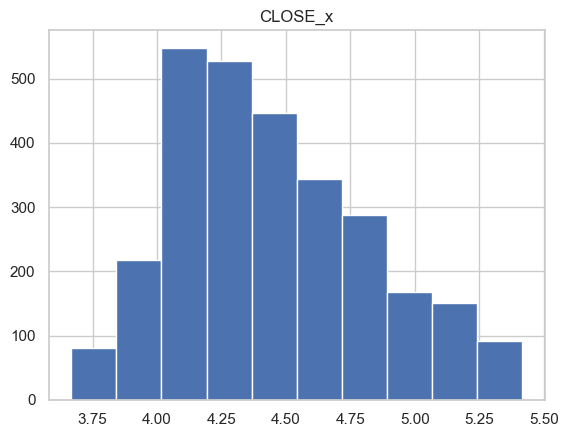

In [68]:
y_train_front_log_transformed.hist() #code to check

/Users/rg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


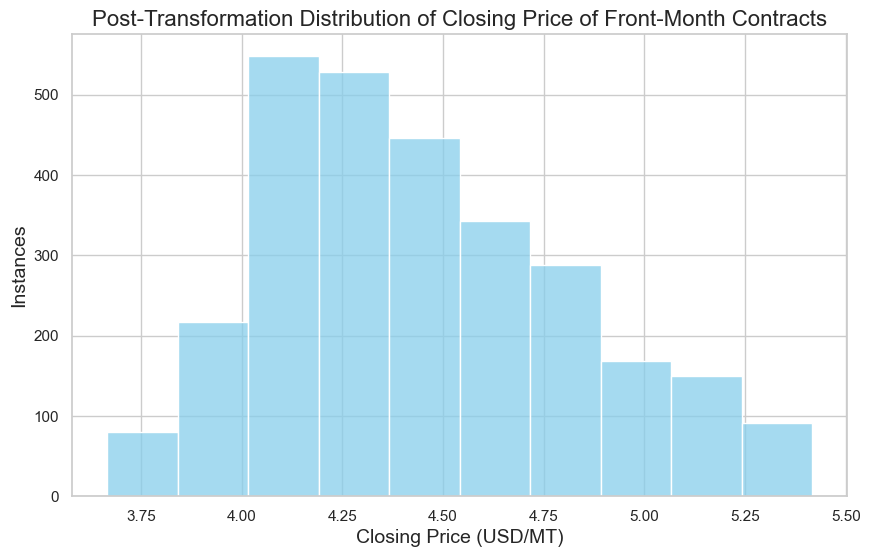

In [69]:
#Plotting post-transformation distribution of front-month closing price

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(y_train_front_log_transformed['CLOSE_x'], bins=10, kde=False, color='skyblue')

plt.title('Post-Transformation Distribution of Closing Price of Front-Month Contracts', fontsize=16)
plt.xlabel('Closing Price (USD/MT)', fontsize=14)
plt.ylabel('Instances', fontsize=14)

plt.show()

In [71]:
#Initialising a log transformer front-month y datasets 
log_transformer_4 = FunctionTransformer(np.log1p, validate=False)

#Applying transformer to test target sets

y_train_second_log_transformed= log_transformer_4.fit_transform(y_train_second)
y_test_second_log_transformed = log_transformer_4.transform(y_test_second)

array([[<Axes: title={'center': 'CLOSE_y'}>]], dtype=object)

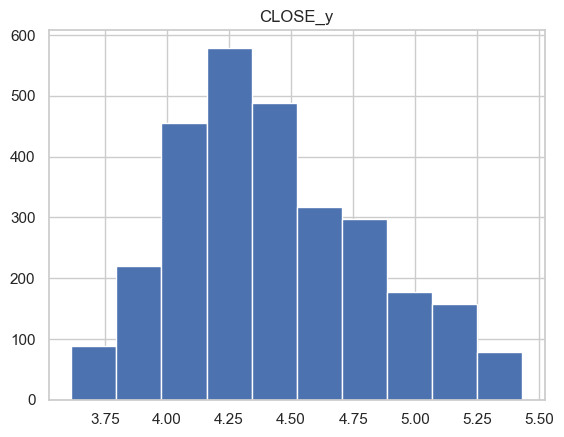

In [72]:
y_train_second_log_transformed.hist() #code to check

/Users/rg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


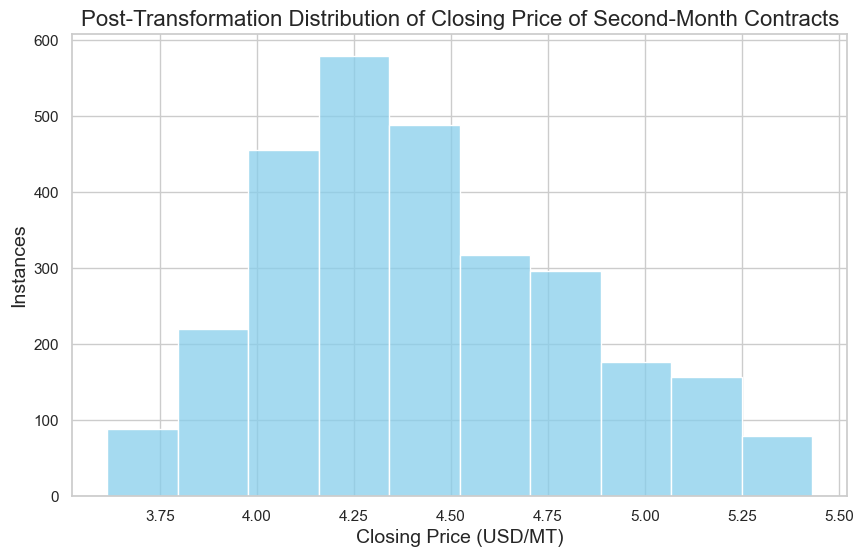

In [95]:
#Plotting post-transformation distribution of second-month closing price

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(y_train_second_log_transformed['CLOSE_y'], bins=10, kde=False, color='skyblue')

plt.title('Post-Transformation Distribution of Closing Price of Second-Month Contracts', fontsize=16)
plt.xlabel('Closing Price (USD/MT)', fontsize=14)
plt.ylabel('Instances', fontsize=14)

plt.show()

The skewness of the training data has been evidently improved through the log-transformation for both X and y. The bi-modal distributions observed have been addressed by way of adding the identified clusters as additional X columns. 

# Feature Engineering <a class="anchor" id="feature-engineering"></a>

<Axes: >

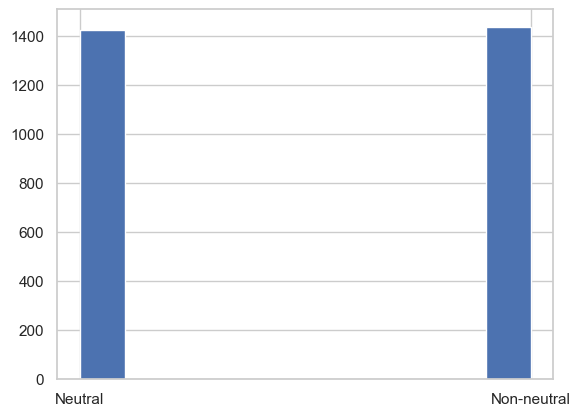

In [75]:
X_train_front_log_transformed['Overall Sentiment'].hist()

In [76]:
X_train_front_log_transformed = create_dummy(X_train_front_log_transformed, 'Overall Sentiment') 

In [77]:
X_train_front_log_transformed.head(10)

,Date,Year,Month,Day,HIGH_x_log,LOW_x_log,OPEN_x_log,VOLUME_x_log,HIGH_y_log,LOW_y_log,...,brazil_daily_export_log,row_daily_export_log,polarity_avg_daily_log,article_count_daily_log,stocks_daily_log,flows_daily_total_log_cluster,china_daily_import_log_cluster,brazil_daily_export_log_cluster,row_daily_export_log_cluster,Sentiment__Non-neutral
0,2015-01-02,2015,1,2,4.287029,4.287029,4.287029,1.791759,4.283862,4.262257,...,12.710191,11.857122,0.0,0.0,0.178565,0,0,1,0,0
1,2015-01-03,2015,1,3,4.287029,4.287029,4.287029,1.791759,4.283862,4.262257,...,0.000000,11.139231,0.0,0.0,0.178565,0,0,0,0,0
2,2015-01-04,2015,1,4,4.287029,4.287029,4.287029,1.791759,4.283862,4.262257,...,13.328023,11.739916,0.0,0.0,0.178565,0,0,1,0,0
3,2015-01-05,2015,1,5,4.287029,4.287029,4.287029,1.791759,4.283862,4.262257,...,15.073926,13.854670,0.0,0.0,0.178565,1,1,1,0,0
4,2015-01-06,2015,1,6,4.287029,4.287029,4.287029,1.791759,4.283862,4.262257,...,11.577428,12.263833,0.0,0.0,0.178565,0,0,1,0,0
5,2015-01-07,2015,1,7,4.281930,4.281930,4.281930,2.054124,4.269697,4.261693,...,11.261506,0.000000,0.0,0.0,0.178565,0,0,1,1,0
6,2015-01-08,2015,1,8,4.276805,4.276805,4.276805,2.261763,4.265493,4.261270,...,0.000000,0.000000,0.0,0.0,0.178565,0,0,0,1,0
7,2015-01-09,2015,1,9,4.271654,4.271654,4.271654,2.433613,4.259294,4.253056,...,12.744333,10.969209,0.0,0.0,0.178565,0,0,1,0,0
8,2015-01-10,2015,1,10,4.271654,4.271654,4.271654,2.433613,4.259294,4.253056,...,12.050039,10.686225,0.0,0.0,0.178565,0,0,1,0,0
9,2015-01-11,2015,1,11,4.271654,4.271654,4.271654,2.433613,4.259294,4.253056,...,0.000000,0.000000,0.0,0.0,0.178565,0,0,0,1,0


In [78]:
#Repeating on test 

X_test_front_log_transformed = create_dummy(X_test_front_log_transformed, 'Overall Sentiment') 

In [79]:
X_test_front_log_transformed.head()

,Date,Year,Month,Day,HIGH_x_log,LOW_x_log,OPEN_x_log,VOLUME_x_log,HIGH_y_log,LOW_y_log,...,brazil_daily_export_log,row_daily_export_log,polarity_avg_daily_log,article_count_daily_log,stocks_daily_log,flows_daily_total_log_cluster,china_daily_import_log_cluster,brazil_daily_export_log_cluster,row_daily_export_log_cluster,Sentiment__Non-neutral
0,2022-11-01,2022,11,1,4.403666,4.354784,4.378270,9.392245,4.383276,4.334017,...,12.061211,0.000000,0.022658,1.609438,0.063405,0,0,0,1,1
1,2022-11-02,2022,11,2,4.431412,4.387636,4.394449,9.913487,4.412192,4.365008,...,13.110361,12.851777,0.000000,0.000000,0.063405,0,0,0,0,0
2,2022-11-03,2022,11,3,4.439116,4.413404,4.420045,9.462110,4.419443,4.391977,...,12.528012,12.023927,-0.005893,1.386294,0.063405,0,0,0,0,1
3,2022-11-04,2022,11,4,4.543295,4.428433,4.434382,10.185956,4.455800,4.416428,...,12.949668,10.906993,0.000000,0.000000,0.063405,0,0,0,0,0
4,2022-11-05,2022,11,5,4.543295,4.428433,4.434382,10.185956,4.455800,4.416428,...,12.763133,12.811335,0.000000,0.000000,0.063405,0,0,0,0,0


In [80]:
#For second-month contracts 

X_train_second_log_transformed = create_dummy(X_train_second_log_transformed, 'Overall Sentiment') 

In [81]:
X_train_second_log_transformed.head()

,Date,Year,Month,Day,HIGH_x_log,LOW_x_log,OPEN_x_log,VOLUME_x_log,HIGH_y_log,LOW_y_log,...,brazil_daily_export_log,row_daily_export_log,polarity_avg_daily_log,article_count_daily_log,stocks_daily_log,flows_daily_total_log_cluster,china_daily_import_log_cluster,brazil_daily_export_log_cluster,row_daily_export_log_cluster,Sentiment__Non-neutral
0,2015-01-02,2015,1,2,4.287029,4.287029,4.287029,1.791759,4.283862,4.262257,...,12.710191,11.857122,0.0,0.0,0.178565,0,0,1,0,0
1,2015-01-03,2015,1,3,4.287029,4.287029,4.287029,1.791759,4.283862,4.262257,...,0.000000,11.139231,0.0,0.0,0.178565,0,0,0,0,0
2,2015-01-04,2015,1,4,4.287029,4.287029,4.287029,1.791759,4.283862,4.262257,...,13.328023,11.739916,0.0,0.0,0.178565,0,0,1,0,0
3,2015-01-05,2015,1,5,4.287029,4.287029,4.287029,1.791759,4.283862,4.262257,...,15.073926,13.854670,0.0,0.0,0.178565,1,1,1,0,0
4,2015-01-06,2015,1,6,4.287029,4.287029,4.287029,1.791759,4.283862,4.262257,...,11.577428,12.263833,0.0,0.0,0.178565,0,0,1,0,0


In [82]:
#Repeating on test 

X_test_second_log_transformed = create_dummy(X_test_second_log_transformed, 'Overall Sentiment') 

In [83]:
X_test_second_log_transformed.head()

,Date,Year,Month,Day,HIGH_x_log,LOW_x_log,OPEN_x_log,VOLUME_x_log,HIGH_y_log,LOW_y_log,...,brazil_daily_export_log,row_daily_export_log,polarity_avg_daily_log,article_count_daily_log,stocks_daily_log,flows_daily_total_log_cluster,china_daily_import_log_cluster,brazil_daily_export_log_cluster,row_daily_export_log_cluster,Sentiment__Non-neutral
0,2022-11-01,2022,11,1,4.403666,4.354784,4.378270,9.392245,4.383276,4.334017,...,12.061211,0.000000,0.022658,1.609438,0.063405,0,0,0,1,1
1,2022-11-02,2022,11,2,4.431412,4.387636,4.394449,9.913487,4.412192,4.365008,...,13.110361,12.851777,0.000000,0.000000,0.063405,0,0,0,0,0
2,2022-11-03,2022,11,3,4.439116,4.413404,4.420045,9.462110,4.419443,4.391977,...,12.528012,12.023927,-0.005893,1.386294,0.063405,0,0,0,0,1
3,2022-11-04,2022,11,4,4.543295,4.428433,4.434382,10.185956,4.455800,4.416428,...,12.949668,10.906993,0.000000,0.000000,0.063405,0,0,0,0,0
4,2022-11-05,2022,11,5,4.543295,4.428433,4.434382,10.185956,4.455800,4.416428,...,12.763133,12.811335,0.000000,0.000000,0.063405,0,0,0,0,0


In [84]:
summary_df_1

,column,cluster,count,mean,std,min,25%,50%,75%,max
0,flows_daily_total_log,0,2454.0,14.636904,0.274360,12.154931,14.497962,14.659566,14.809717,15.785263
1,flows_daily_total_log,1,405.0,16.862345,0.234880,16.106001,16.726109,16.871557,17.016923,17.503741
2,china_daily_import_log,0,2454.0,14.348769,0.317700,10.057590,14.201098,14.373177,14.551312,15.188620
3,china_daily_import_log,1,405.0,16.584177,0.265265,15.759572,16.407613,16.589850,16.767287,17.294619
4,brazil_daily_export_log,0,360.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,brazil_daily_export_log,1,2499.0,13.144643,1.029580,8.879540,12.451772,13.011521,13.545572,16.305862
6,row_daily_export_log,0,2439.0,12.468368,1.082404,6.919073,11.992232,12.414870,12.916249,15.790039
7,row_daily_export_log,1,420.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [85]:
X_train_front_log_transformed.columns

Index(['Date', 'Year', 'Month', 'Day', 'HIGH_x_log', 'LOW_x_log', 'OPEN_x_log',
       'VOLUME_x_log', 'HIGH_y_log', 'LOW_y_log', 'OPEN_y_log', 'CLOSE_y_log',
       'VOLUME_y_log', 'flows_daily_total_log', 'china_daily_import_log',
       'row_daily_import_log', 'aus_daily_export_log',
       'brazil_daily_export_log', 'row_daily_export_log',
       'polarity_avg_daily_log', 'article_count_daily_log', 'stocks_daily_log',
       'flows_daily_total_log_cluster', 'china_daily_import_log_cluster',
       'brazil_daily_export_log_cluster', 'row_daily_export_log_cluster',
       'Sentiment__Non-neutral'],
      dtype='object')

In [86]:
#Creating dummy variables for bi-modal clusters for front-month contracts
X_train_front_log_transformed = create_dummies_with_reference(X_train_front_log_transformed , 'flows_daily_total_log_cluster', 
                                                              reference_category=0, suffix='high_activity')

X_train_front_log_transformed = create_dummies_with_reference(X_train_front_log_transformed , 'china_daily_import_log_cluster', 
                                                              reference_category=0, suffix='high_activity')

X_train_front_log_transformed = create_dummies_with_reference(X_train_front_log_transformed , 'brazil_daily_export_log_cluster', 
                                                              reference_category=0, suffix='active')

X_train_front_log_transformed = create_dummies_with_reference(X_train_front_log_transformed , 'row_daily_export_log_cluster', 
                                                              reference_category=1, suffix='active')

In [87]:
X_train_front_log_transformed.head()

,Date,Year,Month,Day,HIGH_x_log,LOW_x_log,OPEN_x_log,VOLUME_x_log,HIGH_y_log,LOW_y_log,...,brazil_daily_export_log,row_daily_export_log,polarity_avg_daily_log,article_count_daily_log,stocks_daily_log,Sentiment__Non-neutral,flows_daily_total_log_cluster_high_activity,china_daily_import_log_cluster_high_activity,brazil_daily_export_log_cluster_active,row_daily_export_log_cluster_active
0,2015-01-02,2015,1,2,4.287029,4.287029,4.287029,1.791759,4.283862,4.262257,...,12.710191,11.857122,0.0,0.0,0.178565,0,0,0,1,1
1,2015-01-03,2015,1,3,4.287029,4.287029,4.287029,1.791759,4.283862,4.262257,...,0.000000,11.139231,0.0,0.0,0.178565,0,0,0,0,1
2,2015-01-04,2015,1,4,4.287029,4.287029,4.287029,1.791759,4.283862,4.262257,...,13.328023,11.739916,0.0,0.0,0.178565,0,0,0,1,1
3,2015-01-05,2015,1,5,4.287029,4.287029,4.287029,1.791759,4.283862,4.262257,...,15.073926,13.854670,0.0,0.0,0.178565,0,1,1,1,1
4,2015-01-06,2015,1,6,4.287029,4.287029,4.287029,1.791759,4.283862,4.262257,...,11.577428,12.263833,0.0,0.0,0.178565,0,0,0,1,1


In [88]:
#Repeating on test 

X_test_front_log_transformed = create_dummies_with_reference(X_test_front_log_transformed , 'flows_daily_total_log_cluster', 
                                                              reference_category=0, suffix='high_activity')

X_test_front_log_transformed = create_dummies_with_reference(X_test_front_log_transformed , 'china_daily_import_log_cluster', 
                                                              reference_category=0, suffix='high_activity')

X_test_front_log_transformed = create_dummies_with_reference(X_test_front_log_transformed , 'brazil_daily_export_log_cluster', 
                                                              reference_category=0, suffix='active')

X_test_front_log_transformed = create_dummies_with_reference(X_test_front_log_transformed , 'row_daily_export_log_cluster', 
                                                              reference_category=1, suffix='active')

In [89]:
#Creating dummy variables for bi-modal clusters for second-month contracts
X_train_second_log_transformed = create_dummies_with_reference(X_train_second_log_transformed , 'flows_daily_total_log_cluster', 
                                                              reference_category=0, suffix='high_activity')

X_train_second_log_transformed = create_dummies_with_reference(X_train_second_log_transformed , 'china_daily_import_log_cluster', 
                                                              reference_category=0, suffix='high_activity')

X_train_second_log_transformed = create_dummies_with_reference(X_train_second_log_transformed , 'brazil_daily_export_log_cluster', 
                                                              reference_category=0, suffix='active')

X_train_second_log_transformed = create_dummies_with_reference(X_train_second_log_transformed , 'row_daily_export_log_cluster', 
                                                              reference_category=1, suffix='active')

In [90]:
X_train_second_log_transformed.head()

,Date,Year,Month,Day,HIGH_x_log,LOW_x_log,OPEN_x_log,VOLUME_x_log,HIGH_y_log,LOW_y_log,...,brazil_daily_export_log,row_daily_export_log,polarity_avg_daily_log,article_count_daily_log,stocks_daily_log,Sentiment__Non-neutral,flows_daily_total_log_cluster_high_activity,china_daily_import_log_cluster_high_activity,brazil_daily_export_log_cluster_active,row_daily_export_log_cluster_active
0,2015-01-02,2015,1,2,4.287029,4.287029,4.287029,1.791759,4.283862,4.262257,...,12.710191,11.857122,0.0,0.0,0.178565,0,0,0,1,1
1,2015-01-03,2015,1,3,4.287029,4.287029,4.287029,1.791759,4.283862,4.262257,...,0.000000,11.139231,0.0,0.0,0.178565,0,0,0,0,1
2,2015-01-04,2015,1,4,4.287029,4.287029,4.287029,1.791759,4.283862,4.262257,...,13.328023,11.739916,0.0,0.0,0.178565,0,0,0,1,1
3,2015-01-05,2015,1,5,4.287029,4.287029,4.287029,1.791759,4.283862,4.262257,...,15.073926,13.854670,0.0,0.0,0.178565,0,1,1,1,1
4,2015-01-06,2015,1,6,4.287029,4.287029,4.287029,1.791759,4.283862,4.262257,...,11.577428,12.263833,0.0,0.0,0.178565,0,0,0,1,1


In [91]:
#Repeat on test 

X_test_second_log_transformed = create_dummies_with_reference(X_test_second_log_transformed , 'flows_daily_total_log_cluster', 
                                                              reference_category=0, suffix='high_activity')

X_test_second_log_transformed = create_dummies_with_reference(X_test_second_log_transformed , 'china_daily_import_log_cluster', 
                                                              reference_category=0, suffix='high_activity')

X_test_second_log_transformed = create_dummies_with_reference(X_test_second_log_transformed , 'brazil_daily_export_log_cluster', 
                                                              reference_category=0, suffix='active')

X_test_second_log_transformed = create_dummies_with_reference(X_test_second_log_transformed , 'row_daily_export_log_cluster', 
                                                              reference_category=1, suffix='active')

In [92]:
X_test_second_log_transformed.head()

,Date,Year,Month,Day,HIGH_x_log,LOW_x_log,OPEN_x_log,VOLUME_x_log,HIGH_y_log,LOW_y_log,...,brazil_daily_export_log,row_daily_export_log,polarity_avg_daily_log,article_count_daily_log,stocks_daily_log,Sentiment__Non-neutral,flows_daily_total_log_cluster_high_activity,china_daily_import_log_cluster_high_activity,brazil_daily_export_log_cluster_active,row_daily_export_log_cluster_active
0,2022-11-01,2022,11,1,4.403666,4.354784,4.378270,9.392245,4.383276,4.334017,...,12.061211,0.000000,0.022658,1.609438,0.063405,1,0,0,0,0
1,2022-11-02,2022,11,2,4.431412,4.387636,4.394449,9.913487,4.412192,4.365008,...,13.110361,12.851777,0.000000,0.000000,0.063405,0,0,0,0,1
2,2022-11-03,2022,11,3,4.439116,4.413404,4.420045,9.462110,4.419443,4.391977,...,12.528012,12.023927,-0.005893,1.386294,0.063405,1,0,0,0,1
3,2022-11-04,2022,11,4,4.543295,4.428433,4.434382,10.185956,4.455800,4.416428,...,12.949668,10.906993,0.000000,0.000000,0.063405,0,0,0,0,1
4,2022-11-05,2022,11,5,4.543295,4.428433,4.434382,10.185956,4.455800,4.416428,...,12.763133,12.811335,0.000000,0.000000,0.063405,0,0,0,0,1


In [93]:
#Resetting indices of y datasets

y_train_front_log_transformed.reset_index(inplace=True)
y_train_second_log_transformed.reset_index(inplace=True)

y_test_front_log_transformed.reset_index(inplace=True)
y_test_second_log_transformed.reset_index(inplace=True)

In [1544]:
#Saving log-transformed datasets to csv 
X_train_front_log_transformed.to_csv('X_train_front_log_transformed.csv', index=False)
y_train_front_log_transformed.to_csv('y_train_front_log_transformed.csv', index=False)
X_train_second_log_transformed.to_csv('X_train_second_log_transformed.csv', index=False)
y_train_second_log_transformed.to_csv('y_train_second_log_transformed.csv', index=False)


X_test_front_log_transformed.to_csv('X_test_front_log_transformed.csv', index=False)
y_test_front_log_transformed.to_csv('y_test_front_log_transformed.csv', index=False)
X_test_second_log_transformed.to_csv('X_test_second_log_transformed.csv', index=False)
y_test_second_log_transformed.to_csv('y_test_second_log_transformed.csv', index=False)